Import MDAnalysis Module (https://www.mdanalysis.org/) and Matplotlib <br/> 
Don't forget to add the permissions: <br/>
sudo jupyter-nbextension enable nglview --py --sys-prefix <br/>
sudo  jupyter-nbextension enable --py widgetsnbextension <br/>

In [1]:
%matplotlib nbagg
%matplotlib inline
import MDAnalysis as mda
import MDAnalysis.analysis.leaflet
from matplotlib import rc

import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nglview as nv

import warnings
warnings.filterwarnings('ignore')

pi = np.pi

![](./line_tension_method.png)

<img src="./line_tension_method.png" style="width:550px;height:200px"/>

In [3]:
# indicate the name of the simulation, the path of the data and the .gro and .xtc files to import
# no GM1

name = '_DPPC_DIPC_chol_352'

path = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol/'
path_res = '/home/julie/analysis/bilayers/3-5-2/DPPC_DIPC_chol/line_tension_long/'

path_data = path

fgro = 'start_mb.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_20micros_mb_fixed_t1.xtc'

# name and files for the simulation studied LPT - no GM1

name = '_DPPC_DIPC_chol_352'

path = '/users/cornet/Documents/PhD/Matthieu/3-5-2/sans_GM1/'
path_res = '/users/cornet/Documents/PhD/Matthieu/3-5-2/sans_GM1/line_tension/'

fgro = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1_ref9999ns.gro'
fxtc = 'run_DPPC_DIPC_CHOL_43nm_352_mb_fixed_t1.xtc'

Load xtc and gro files using mda.Universe('struct file','traj file')

In [5]:
u = mda.Universe( path+fgro, path+fxtc)

In [6]:
# number of frames
len(u.trajectory)

20000

In [7]:
sel_all = u.select_atoms("all") #and (name PO4 or name GM5)")

In [8]:
# visualize the bilayer and choose the frame to study

v= nv.show_mdanalysis(sel_all)
v.add_spacefill(sel_all, scale=2.0)
v

A Jupyter Widget

In [9]:
# Leaflet separation

sel_tot = "all and (name PO4 or name GM5)"

u.trajectory[2]
Lf = mda.analysis.leaflet.LeafletFinder(u, 'name PO4 or name GM5')
leaflet0 = Lf.groups(0)
leaflet1 = Lf.groups(1)

l0 = leaflet0.select_atoms(sel_tot).positions
l1 = leaflet1.select_atoms(sel_tot).positions
m_tot = u.select_atoms(sel_tot).positions

print('total number of lipids: %d' % len(m_tot))
print('number of lipids in the upper leaflet: %d + number of lipids in the lower leaflet:%d \n= %d' % (len(l0),len(l1),len(l0)+len(l1)))

if (len(m_tot) != len(l0)+len(l1) ):
    print('PROBLEM!')

total number of lipids: 4840
number of lipids in the upper leaflet: 2420 + number of lipids in the lower leaflet:2420 
= 4840


In [10]:
time_simu = 20 # microseconds
nb_frames_simu = 20000

In [11]:
def modulo(x,a,b):
    if x < a:
        x = x + (b-a)
    elif x >= b:
        x = x - (b-a)
    return x

In [12]:
tmes = 1
t_start = 8000

N = 15 # set the number of boxes into which will be divided the membrane
x_center_b = int(np.floor(N/2))
y_center_b = int(np.floor(N/2))

threshold = 0.6 # composition threshold from which the box is considered Lo, below it is considered Ld

# r and theta pie parameters
nb_r = 10
nb_theta = 20 # need to be even in this case

lq = int(np.floor(nb_theta/2))+1
q = np.arange(nb_theta/2+1) # Fourier index
r_q_pow_list = [[] for r in range(lq)]

R_mean_list = [] # mean radius of the domain
R_0_list = [] # radius of the equivalent non-fluctuating domain

stat = 0

time = []

frame_stack = 0
max_frame_stack = 5 # number of frames where the lipids are summed in the boxes

qmax = 6

params = '_r{}_theta{}_stack{}_tmes{}_qmax{}'.format(nb_r,nb_theta,max_frame_stack,tmes,qmax)
print(params)

_r10_theta20_stack5_tmes1_qmax6


In [11]:
for ts in u.trajectory:

    if (ts.frame%tmes == 0 and ts.frame>=t_start):
        
        print('frame: %d' %ts.frame)
        time.append(ts.frame/ (nb_frames_simu/time_simu))
        
        frame_stack += 1
        print('frame_stack = %d' %frame_stack)

        #determine the min and the max values of the box -------------------------------------------------------
        sel_all = "all and (name PO4 or name GM5)"
        patch = u.select_atoms(sel_all).positions

        xmax = max(patch[:,0])
        ymax = max(patch[:,1])

        xmin = min(patch[:,0])
        ymin = min(patch[:,1])
        
        #select the lipids of the different phases, Lo or Ld ----------------------------------------------------      
        sel_Lo = "all and (name PO4 and resname DPPC)"
        M_Lo = leaflet1.select_atoms(sel_Lo).positions
        M_Lo[:,2] = 1

        sel_Ld = "all and (name PO4 and resname DIPC)"
        M_Ld = leaflet1.select_atoms(sel_Ld).positions
        M_Ld[:,2] = 0

        M_coords = np.concatenate((M_Lo, M_Ld), axis = 0)
        
        # set the spatial x and y step to divide the membrane --------------------------------------------------
        dx = (xmax-xmin)/N
        dy = (ymax-ymin)/N
        
        # leaflet 1
        # divide the leaflet into a grid and calculate the concentration ratio in each box

        bary1 = []

        Mphi1_Lo = np.zeros((N,N))

        for i in range(0,N):
            xs = xmin + i*dx
            for j in range(0,N):
                ys = ymin + j*dy

                # barycenter of all molecules in each box
                sel= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+")"
                b1=leaflet1.select_atoms(sel).centroid().tolist()
                bary1.append(b1)

                # composition rates in each box
                sel_totPC= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+" and name PO4)"
                tot1PC= leaflet1.select_atoms(sel_totPC).positions
                n_tot1PC=len(tot1PC) # total number of PC

                sel_Lo= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname DPPC"
                Lo1= leaflet1.select_atoms(sel_Lo).positions
                n_Lo1=len(Lo1) # number of molecules of the Lo phase (DPPC here)

                sel_Ld= "(prop x>= "+str(xs)+" and prop x< "+str(xs+dx)+" and prop y>= "+str(ys)+" and prop y< "+str(ys+dy)+") and resname DIPC"
                Ld1= leaflet1.select_atoms(sel_Ld).positions
                n_Ld1=len(Ld1) # number of molecules of the Ld phase (DIPC here)

                if  n_tot1PC!=0:
                    phi1_Lo=n_Lo1/n_tot1PC
                else :
                    print('leaflet 1, empty box: i=%d and j=%d' % (i,j))

                Mphi1_Lo[i,j]=phi1_Lo

        bary1=np.array(bary1)
        
        # lower leaflet binary composition -------------------------------------------------------------------------
        Mphi1_bin = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                if Mphi1_Lo[i,j]>= threshold :
                    Mphi1_bin[i,j]=1

        # find the domain larger axis ------------------------------------------------------------------------------
        M_sum = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                M_sum[i,j] = sum(Mphi1_bin[i,:])+sum(Mphi1_bin[:,j])
        val_max = 0
        x_big = 0
        y_big = 0
        for i in range(N):
            for j in range(N):
                if M_sum[i,j]>val_max:
                    val_max = M_sum[i,j]
                    x_big = i
                    y_big = j
        
        # reunify and center the Lo domain -------------------------------------------------------------------------
        vec_cor_b = np.zeros((1,2)) # vector containing the correction to apply to center
        x_cor = x_big - x_center_b
        y_cor = y_big - y_center_b
        
        M_full = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                if Mphi1_bin[i,j]==1:
                    M_full[ modulo(i-x_cor,0,N), modulo(j-y_cor,0,N) ] = Mphi1_bin[i,j]

        vec_cor_b[0,0] = vec_cor_b[0,0] + x_cor
        vec_cor_b[0,1] = vec_cor_b[0,1] + y_cor
        
        # discard the isolated Lo boxes
        for i in range(N):
            for j in range(N):
                if (M_full[modulo(i-1,0,N),modulo(j-1,0,N)]==0 and M_full[modulo(i-1,0,N),j]==0 and M_full[modulo(i-1,0,N),modulo(j+1,0,N)]==0 and M_full[i,modulo(j-1,0,N)]==0 and M_full[i,modulo(j+1,0,N)]==0 and M_full[modulo(i+1,0,N),modulo(j-1,0,N)]==0 and M_full[modulo(i+1,0,N),j]==0 and M_full[modulo(i+1,0,N),modulo(j+1,0,N)]==0):
                    M_full[i,j] = 0
        
        # determine the barycenter of the domain and its width ----------------------------------------------------------------
        nb_Lo = int(np.sum(M_full))

        coords_Lo = np.zeros((nb_Lo,2))
        l = 0
        # domain barycenter
        for i in range(N):
            for j in range(N):
                if M_full[i,j] == 1 :
                    coords_Lo[l][0] = i
                    coords_Lo[l][1] = j
                    l += 1

        box_x_mean = np.mean(coords_Lo[:,0])
        box_y_mean = np.mean(coords_Lo[:,1])
        
        # domain width
        box_x_max = 0
        box_y_max = 0

        for i in range(N):
            for j in range(N):
                if M_full[i,j]==1 and np.abs(i-box_x_mean) > box_x_max:
                    box_x_max = np.abs(i-box_x_mean)
                if M_full[i,j]==1 and np.abs(j-box_y_mean) > box_y_max:
                    box_y_max = np.abs(j-box_y_mean)
        box_max = np.ceil(max(box_x_max,box_y_max))
        
        x_mean_b = int(round(box_x_mean))
        y_mean_b = int(round(box_y_mean))
        
        # second correction to recenter the domain -----------------------------------------------------------------
        x_cor = x_mean_b - x_center_b
        y_cor = y_mean_b - y_center_b

        M_center = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                if M_full[i,j]==1:
                    M_center[ modulo(i-x_cor,0,N), modulo(j-y_cor,0,N) ] = M_full[i,j]

        vec_cor_b[0,0] = vec_cor_b[0,0] + x_cor
        vec_cor_b[0,1] = vec_cor_b[0,1] + y_cor
        
        plt.imshow(M_center)
        plt.savefig(path_res+'im'+name+params+'t'+str(ts.frame)+'.pdf', format='pdf',bbox_inches='tight')
        plt.clf()
        
        # convert the values in real space units -----------------------------------------------------------------------
        x_center = (xmin+xmax)/2
        y_center = (ymin+ymax)/2
        
        if(ts.frame==t_start):
            r_max = np.floor((xmax-xmin)/2)*0.9
            delta_r = r_max*10**(-10)/nb_r # ici en m
        
        
        vec_cor = vec_cor_b /N * (ymax-ymin)
        
        # center the domain applying the total correction on the lipids --------------------------------------------
        for i in range(len(M_coords)):
            M_coords[i,0] = modulo(M_coords[i,0] - vec_cor[0,0],xmin,xmax)
            M_coords[i,1] = modulo(M_coords[i,1] - vec_cor[0,1],ymin,ymax)
                    
        dr = int(r_max/nb_r)
        dtheta = 2*pi/nb_theta
        
        # divide the leaflet into a pie
        if r_max < np.floor((xmax-xmin)/2)+dr: # condition à voir----------------------------------------------------
            
            x = M_coords[:,0]
            y = M_coords[:,1]
            print('done')
            stat += 1
            
            x_pie_r = [[] for r in range(nb_r)]
            y_pie_r = [[] for r in range(nb_r)]
            pie_r = [[] for r in range(nb_r)]

            x_pie_theta = [[] for t in range(nb_theta)]
            y_pie_theta = [[] for t in range(nb_theta)]
            pie_theta = [[] for t in range(nb_theta)]

            r_crown = 0
            for r in range(nb_r):

                x_r = []
                y_r = []
                i_r = []

                r_crown = r_crown+dr

                for i in range(len(M_coords)):
                    xi = M_coords[i,0]
                    yi = M_coords[i,1]

                    if (xi-x_center)**2+(yi-y_center)**2 < r_crown**2 and (xi-x_center)**2+(yi-y_center)**2 >= (r_crown-dr)**2:
                        x_r.append(xi)
                        y_r.append(yi)
                        i_r.append(i)

                x_pie_r[r] = x_r
                y_pie_r[r] = y_r
                pie_r[r] = i_r

            for i in range(len(M_coords)):
                xi = M_coords[i,0]
                yi = M_coords[i,1]

                theta = np.arccos((xi-x_center)/np.sqrt((xi-x_center)**2+(yi-y_center)**2))
                t = int(np.floor(theta/dtheta))
                if yi<y_center : # if angle > pi
                    t = nb_theta-t-1

                x_pie_theta[t].append(xi)
                y_pie_theta[t].append(yi)
                pie_theta[t].append(i)
            
            
            # divide the leaflet into a pie - Lo lipids only
            l_Lo = int(np.sum(M_coords[:,2]))
            M_coords_Lo = np.zeros((l_Lo,3))

            j = 0
            for i in range(len(M_coords)):
                if M_coords[i,2] == 1:
                    M_coords_Lo[j] = M_coords[i]
                    j+=1

            x_Lo = M_coords_Lo[:,0]
            y_Lo = M_coords_Lo[:,1]

            x_pie_r_Lo = [[] for r in range(nb_r)]
            y_pie_r_Lo = [[] for r in range(nb_r)]
            pie_r_Lo = [[] for r in range(nb_r)]

            x_pie_theta_Lo = [[] for t in range(nb_theta)]
            y_pie_theta_Lo = [[] for t in range(nb_theta)]
            pie_theta_Lo = [[] for t in range(nb_theta)]


            r_crown = 0
            for r in range(nb_r):

                x_r = []
                y_r = []
                i_r = []

                r_crown = r_crown+dr

                for i in range(len(M_coords_Lo)):

                    xi = M_coords_Lo[i,0]
                    yi = M_coords_Lo[i,1]

                    if (xi-x_center)**2+(yi-y_center)**2 < r_crown**2 and (xi-x_center)**2+(yi-y_center)**2 >= (r_crown-dr)**2:
                        x_r.append(xi)
                        y_r.append(yi)
                        i_r.append(i)

                x_pie_r_Lo[r] = x_r
                y_pie_r_Lo[r] = y_r
                pie_r_Lo[r] = i_r

            for i in range(len(M_coords_Lo)):
                xi = M_coords_Lo[i,0]
                yi = M_coords_Lo[i,1]

                theta = np.arccos((xi-x_center)/np.sqrt((xi-x_center)**2+(yi-y_center)**2))
                t = int(np.floor(theta/dtheta))
                if yi<y_center : # if angle > pi
                    t = nb_theta-t-1

                x_pie_theta_Lo[t].append(xi)
                y_pie_theta_Lo[t].append(yi)
                pie_theta_Lo[t].append(i)
                    
            
            # if we have already summed max_frame_stack frames, the pies are reset
            if (ts.frame == t_start or frame_stack > max_frame_stack) :
                # create and fill in the pie r, theta -------------------------------------------------------
                pie = [[[] for t in range(nb_theta)] for r in range(nb_r)]
                print('RESET')
                
            for r in range(nb_r):
                for t in range(nb_theta):
                    for l in range(len(pie_r[r])):
                        if (pie_r[r][l] in pie_theta[t]):
                            pie[r][t].append(pie_r[r][l])

                # create the and fill in the pie r, theta -------------------------------------------------------
                if (ts.frame == t_start or frame_stack > max_frame_stack) :
                    
                    frame_stack = 0
                    
                    pie_Lo = [[[] for t in range(nb_theta)] for r in range(nb_r)]
                
            for r in range(nb_r):
                for t in range(nb_theta):
                    for l in range(len(pie_r_Lo[r])):
                        if (pie_r_Lo[r][l] in pie_theta_Lo[t]):
                            pie_Lo[r][t].append(pie_r_Lo[r][l])
            
            print('longueur : %d\n' %len(pie[2][0]))
            
#-----------if enough frames have been summed
                
            if (frame_stack == max_frame_stack) :

                # binarisation of the pie -------------------------------------------------------------------------
                M_pie_bin = np.zeros((nb_r, nb_theta))

                for r in range(nb_r):
                    for t in range(nb_theta):
                        if r==0:
                            M_pie_bin[r,t]=1
                        elif(len(pie_Lo[r][t])/len(pie[r][t])>=threshold):
                            M_pie_bin[r,t]=1
                                
                # determination of the Lo-Ld boundary --------------------------------------------------------------
                boundary = [[],[]]

                for t in range(nb_theta):
                    boundary[0].append(t)
                    b_found = 0
                    for r in range(0,nb_r-2,1):

                        if M_pie_bin[r,t]==1 and (M_pie_bin[r+1,t]==0 or r+1>=nb_r) and (M_pie_bin[r+2,t]==0 or r+2>=nb_r):
                            b_found = 1
                            boundary[1].append(r)
                    if b_found == 0:
                        if M_pie_bin[nb_r-2,t]==1 and M_pie_bin[nb_r-1,t]!=1:
                            boundary[1].append(nb_r-2)
                        elif M_pie_bin[nb_r-1,t]==1:
                            boundary[1].append(nb_r-1)

                theta_l = np.array(boundary[0])
                r_theta = np.array(boundary[1])
                print(r_theta)
                
                # mean radius of the domain
                R_mean_list.append(np.mean(r_theta))
                
                # radius of the equivalent non-fluctuating domain
                S = 0
                for t in range(nb_theta):
                    for r in range(1,boundary[1][t]+1,1):
                        S = S + pi*((r*delta_r)**2-((r-1)*delta_r)**2)/nb_theta
                R_0_dom = np.sqrt(S/pi) # en m
                R_0_list.append(R_0_dom)

                # Fourier Transform of the boundary : r = f(theta) --------------------------------------------------
                r_q = np.fft.rfft(r_theta)
                r_q = r_q*2*pi/nb_theta
                r_q_pow = abs(r_q)**2

                print('stat = %d' %stat)
                for i in range(lq):
                    r_q_pow_list[i].append(r_q_pow[i])


frame: 8000
frame_stack = 1
done
RESET
longueur : 3

frame: 8001
frame_stack = 1
done
longueur : 5

frame: 8002
frame_stack = 2
done
longueur : 8

frame: 8003
frame_stack = 3
done
longueur : 12

frame: 8004
frame_stack = 4
done
longueur : 16

frame: 8005
frame_stack = 5
done
longueur : 20

[5 4 5 6 6 5 6 6 6 6 6 3 5 6 6 6 6 6 6 6]
stat = 6
frame: 8006
frame_stack = 6
done
RESET
longueur : 4

frame: 8007
frame_stack = 1
done
longueur : 9

frame: 8008
frame_stack = 2
done
longueur : 12

frame: 8009
frame_stack = 3
done
longueur : 16

frame: 8010
frame_stack = 4
done
longueur : 19

frame: 8011
frame_stack = 5
done
longueur : 24

[5 4 5 5 6 5 6 6 6 6 6 5 4 6 6 6 6 6 6 7]
stat = 12
frame: 8012
frame_stack = 6
done
RESET
longueur : 4

frame: 8013
frame_stack = 1
done
longueur : 7

frame: 8014
frame_stack = 2
done
longueur : 10

frame: 8015
frame_stack = 3
done
longueur : 15

frame: 8016
frame_stack = 4
done
longueur : 20

frame: 8017
frame_stack = 5
done
longueur : 23

[5 4 5 5 6 5 6 6 6 6 6

done
longueur : 28

[6 6 6 6 5 5 5 6 4 5 5 5 5 5 4 4 7 6 6 5]
stat = 144
frame: 8144
frame_stack = 6
done
RESET
longueur : 4

frame: 8145
frame_stack = 1
done
longueur : 8

frame: 8146
frame_stack = 2
done
longueur : 13

frame: 8147
frame_stack = 3
done
longueur : 17

frame: 8148
frame_stack = 4
done
longueur : 22

frame: 8149
frame_stack = 5
done
longueur : 26

[6 6 6 6 4 5 5 5 5 6 5 5 5 4 4 4 5 6 6 5]
stat = 150
frame: 8150
frame_stack = 6
done
RESET
longueur : 4

frame: 8151
frame_stack = 1
done
longueur : 9

frame: 8152
frame_stack = 2
done
longueur : 14

frame: 8153
frame_stack = 3
done
longueur : 17

frame: 8154
frame_stack = 4
done
longueur : 21

frame: 8155
frame_stack = 5
done
longueur : 25

[6 6 6 6 5 5 6 6 5 6 5 5 5 4 4 4 6 5 5 5]
stat = 156
frame: 8156
frame_stack = 6
done
RESET
longueur : 6

frame: 8157
frame_stack = 1
done
longueur : 8

frame: 8158
frame_stack = 2
done
longueur : 11

frame: 8159
frame_stack = 3
done
longueur : 16

frame: 8160
frame_stack = 4
done
longueur

done
longueur : 18

frame: 8287
frame_stack = 5
done
longueur : 21

[5 6 5 5 4 5 4 6 5 6 5 6 6 5 4 5 7 6 5 5]
stat = 288
frame: 8288
frame_stack = 6
done
RESET
longueur : 4

frame: 8289
frame_stack = 1
done
longueur : 7

frame: 8290
frame_stack = 2
done
longueur : 9

frame: 8291
frame_stack = 3
done
longueur : 13

frame: 8292
frame_stack = 4
done
longueur : 17

frame: 8293
frame_stack = 5
done
longueur : 22

[5 6 5 6 4 5 5 6 5 5 5 5 6 5 4 5 7 5 6 6]
stat = 294
frame: 8294
frame_stack = 6
done
RESET
longueur : 4

frame: 8295
frame_stack = 1
done
longueur : 7

frame: 8296
frame_stack = 2
done
longueur : 13

frame: 8297
frame_stack = 3
done
longueur : 17

frame: 8298
frame_stack = 4
done
longueur : 20

frame: 8299
frame_stack = 5
done
longueur : 24

[5 5 6 6 5 6 5 6 5 6 5 5 5 4 3 4 6 5 5 6]
stat = 300
frame: 8300
frame_stack = 6
done
RESET
longueur : 4

frame: 8301
frame_stack = 1
done
longueur : 8

frame: 8302
frame_stack = 2
done
longueur : 12

frame: 8303
frame_stack = 3
done
longueur 

longueur : 14

frame: 8429
frame_stack = 3
done
longueur : 19

frame: 8430
frame_stack = 4
done
longueur : 23

frame: 8431
frame_stack = 5
done
longueur : 27

[4 5 7 5 5 4 6 6 5 7 4 6 4 3 4 7 6 5 5 7]
stat = 432
frame: 8432
frame_stack = 6
done
RESET
longueur : 2

frame: 8433
frame_stack = 1
done
longueur : 5

frame: 8434
frame_stack = 2
done
longueur : 10

frame: 8435
frame_stack = 3
done
longueur : 14

frame: 8436
frame_stack = 4
done
longueur : 18

frame: 8437
frame_stack = 5
done
longueur : 23

[5 6 7 6 5 4 6 6 6 6 5 6 5 3 4 5 6 6 6 7]
stat = 438
frame: 8438
frame_stack = 6
done
RESET
longueur : 4

frame: 8439
frame_stack = 1
done
longueur : 8

frame: 8440
frame_stack = 2
done
longueur : 11

frame: 8441
frame_stack = 3
done
longueur : 15

frame: 8442
frame_stack = 4
done
longueur : 18

frame: 8443
frame_stack = 5
done
longueur : 24

[4 6 7 5 4 4 6 5 5 6 5 6 5 3 5 6 6 6 6 7]
stat = 444
frame: 8444
frame_stack = 6
done
RESET
longueur : 4

frame: 8445
frame_stack = 1
done
longueur : 7

done
longueur : 8

frame: 8572
frame_stack = 2
done
longueur : 12

frame: 8573
frame_stack = 3
done
longueur : 17

frame: 8574
frame_stack = 4
done
longueur : 21

frame: 8575
frame_stack = 5
done
longueur : 26

[5 6 6 7 6 5 6 6 5 5 5 5 7 4 4 4 5 5 5 6]
stat = 576
frame: 8576
frame_stack = 6
done
RESET
longueur : 3

frame: 8577
frame_stack = 1
done
longueur : 7

frame: 8578
frame_stack = 2
done
longueur : 11

frame: 8579
frame_stack = 3
done
longueur : 14

frame: 8580
frame_stack = 4
done
longueur : 17

frame: 8581
frame_stack = 5
done
longueur : 23

[6 6 6 6 5 5 5 6 5 5 5 6 7 5 4 5 6 5 6 6]
stat = 582
frame: 8582
frame_stack = 6
done
RESET
longueur : 2

frame: 8583
frame_stack = 1
done
longueur : 4

frame: 8584
frame_stack = 2
done
longueur : 8

frame: 8585
frame_stack = 3
done
longueur : 13

frame: 8586
frame_stack = 4
done
longueur : 17

frame: 8587
frame_stack = 5
done
longueur : 22

[6 6 7 5 6 5 6 5 4 4 5 6 7 4 4 5 5 5 6 7]
stat = 588
frame: 8588
frame_stack = 6
done
RESET
longueur

done
RESET
longueur : 3

frame: 8715
frame_stack = 1
done
longueur : 7

frame: 8716
frame_stack = 2
done
longueur : 11

frame: 8717
frame_stack = 3
done
longueur : 15

frame: 8718
frame_stack = 4
done
longueur : 18

frame: 8719
frame_stack = 5
done
longueur : 22

[7 7 5 4 5 6 6 6 6 5 5 6 5 5 5 5 5 4 5 5]
stat = 720
frame: 8720
frame_stack = 6
done
RESET
longueur : 3

frame: 8721
frame_stack = 1
done
longueur : 9

frame: 8722
frame_stack = 2
done
longueur : 13

frame: 8723
frame_stack = 3
done
longueur : 18

frame: 8724
frame_stack = 4
done
longueur : 22

frame: 8725
frame_stack = 5
done
longueur : 28

[7 6 5 5 4 6 6 6 6 6 5 6 6 5 5 5 4 5 4 4]
stat = 726
frame: 8726
frame_stack = 6
done
RESET
longueur : 5

frame: 8727
frame_stack = 1
done
longueur : 8

frame: 8728
frame_stack = 2
done
longueur : 11

frame: 8729
frame_stack = 3
done
longueur : 17

frame: 8730
frame_stack = 4
done
longueur : 22

frame: 8731
frame_stack = 5
done
longueur : 26

[6 6 5 5 4 6 6 6 7 6 6 7 6 5 6 5 4 4 5 4]
stat

done
RESET
longueur : 5

frame: 8859
frame_stack = 1
done
longueur : 10

frame: 8860
frame_stack = 2
done
longueur : 17

frame: 8861
frame_stack = 3
done
longueur : 20

frame: 8862
frame_stack = 4
done
longueur : 24

frame: 8863
frame_stack = 5
done
longueur : 29

[7 7 7 5 5 6 6 5 5 4 6 5 5 6 5 7 4 5 6 5]
stat = 864
frame: 8864
frame_stack = 6
done
RESET
longueur : 6

frame: 8865
frame_stack = 1
done
longueur : 12

frame: 8866
frame_stack = 2
done
longueur : 15

frame: 8867
frame_stack = 3
done
longueur : 18

frame: 8868
frame_stack = 4
done
longueur : 21

frame: 8869
frame_stack = 5
done
longueur : 25

[7 7 7 5 5 5 6 6 6 4 6 5 5 6 5 6 5 5 5 5]
stat = 870
frame: 8870
frame_stack = 6
done
RESET
longueur : 4

frame: 8871
frame_stack = 1
done
longueur : 6

frame: 8872
frame_stack = 2
done
longueur : 10

frame: 8873
frame_stack = 3
done
longueur : 15

frame: 8874
frame_stack = 4
done
longueur : 20

frame: 8875
frame_stack = 5
done
longueur : 23

[7 7 7 5 5 6 6 6 6 4 6 6 5 6 5 7 5 5 5 5]
st

done
RESET
longueur : 1

frame: 9003
frame_stack = 1
done
longueur : 3

frame: 9004
frame_stack = 2
done
longueur : 7

frame: 9005
frame_stack = 3
done
longueur : 10

frame: 9006
frame_stack = 4
done
longueur : 14

frame: 9007
frame_stack = 5
done
longueur : 19

[6 6 7 7 5 6 5 5 5 5 6 6 6 5 5 6 6 5 5 5]
stat = 1008
frame: 9008
frame_stack = 6
done
RESET
longueur : 5

frame: 9009
frame_stack = 1
done
longueur : 7

frame: 9010
frame_stack = 2
done
longueur : 8

frame: 9011
frame_stack = 3
done
longueur : 10

frame: 9012
frame_stack = 4
done
longueur : 13

frame: 9013
frame_stack = 5
done
longueur : 19

[5 5 7 7 5 5 6 5 6 6 6 7 5 5 5 6 5 4 3 4]
stat = 1014
frame: 9014
frame_stack = 6
done
RESET
longueur : 3

frame: 9015
frame_stack = 1
done
longueur : 10

frame: 9016
frame_stack = 2
done
longueur : 14

frame: 9017
frame_stack = 3
done
longueur : 19

frame: 9018
frame_stack = 4
done
longueur : 23

frame: 9019
frame_stack = 5
done
longueur : 27

[5 6 6 7 6 5 7 5 6 5 6 7 5 5 5 6 5 5 3 4]
sta

done
longueur : 24

[4 5 6 7 7 6 7 5 5 6 6 6 6 6 6 6 6 5 4 4]
stat = 1146
frame: 9146
frame_stack = 6
done
RESET
longueur : 4

frame: 9147
frame_stack = 1
done
longueur : 10

frame: 9148
frame_stack = 2
done
longueur : 13

frame: 9149
frame_stack = 3
done
longueur : 18

frame: 9150
frame_stack = 4
done
longueur : 22

frame: 9151
frame_stack = 5
done
longueur : 27

[4 5 5 7 7 6 7 6 5 4 6 6 5 6 6 6 5 5 4 4]
stat = 1152
frame: 9152
frame_stack = 6
done
RESET
longueur : 4

frame: 9153
frame_stack = 1
done
longueur : 8

frame: 9154
frame_stack = 2
done
longueur : 12

frame: 9155
frame_stack = 3
done
longueur : 15

frame: 9156
frame_stack = 4
done
longueur : 18

frame: 9157
frame_stack = 5
done
longueur : 21

[4 5 5 7 7 6 7 6 5 4 6 6 5 6 6 6 5 5 4 4]
stat = 1158
frame: 9158
frame_stack = 6
done
RESET
longueur : 3

frame: 9159
frame_stack = 1
done
longueur : 5

frame: 9160
frame_stack = 2
done
longueur : 10

frame: 9161
frame_stack = 3
done
longueur : 15

frame: 9162
frame_stack = 4
done
long

done
longueur : 17

frame: 9288
frame_stack = 4
done
longueur : 22

frame: 9289
frame_stack = 5
done
longueur : 26

[6 5 6 7 7 7 6 6 4 5 6 6 5 5 6 6 5 4 3 4]
stat = 1290
frame: 9290
frame_stack = 6
done
RESET
longueur : 3

frame: 9291
frame_stack = 1
done
longueur : 6

frame: 9292
frame_stack = 2
done
longueur : 9

frame: 9293
frame_stack = 3
done
longueur : 12

frame: 9294
frame_stack = 4
done
longueur : 17

frame: 9295
frame_stack = 5
done
longueur : 19

[6 6 6 7 7 6 6 6 5 5 5 6 5 6 6 6 5 4 3 4]
stat = 1296
frame: 9296
frame_stack = 6
done
RESET
longueur : 3

frame: 9297
frame_stack = 1
done
longueur : 8

frame: 9298
frame_stack = 2
done
longueur : 11

frame: 9299
frame_stack = 3
done
longueur : 14

frame: 9300
frame_stack = 4
done
longueur : 18

frame: 9301
frame_stack = 5
done
longueur : 21

[6 6 6 6 6 6 5 5 5 4 5 6 6 6 6 6 5 4 4 5]
stat = 1302
frame: 9302
frame_stack = 6
done
RESET
longueur : 2

frame: 9303
frame_stack = 1
done
longueur : 7

frame: 9304
frame_stack = 2
done
longue

done
longueur : 8

frame: 9430
frame_stack = 2
done
longueur : 11

frame: 9431
frame_stack = 3
done
longueur : 15

frame: 9432
frame_stack = 4
done
longueur : 20

frame: 9433
frame_stack = 5
done
longueur : 24

[6 7 7 7 6 4 5 4 4 5 5 6 6 6 6 6 6 5 5 6]
stat = 1434
frame: 9434
frame_stack = 6
done
RESET
longueur : 5

frame: 9435
frame_stack = 1
done
longueur : 9

frame: 9436
frame_stack = 2
done
longueur : 12

frame: 9437
frame_stack = 3
done
longueur : 17

frame: 9438
frame_stack = 4
done
longueur : 20

frame: 9439
frame_stack = 5
done
longueur : 24

[4 5 6 6 6 6 5 5 5 6 6 7 6 6 6 6 5 4 5 5]
stat = 1440
frame: 9440
frame_stack = 6
done
RESET
longueur : 3

frame: 9441
frame_stack = 1
done
longueur : 7

frame: 9442
frame_stack = 2
done
longueur : 12

frame: 9443
frame_stack = 3
done
longueur : 16

frame: 9444
frame_stack = 4
done
longueur : 21

frame: 9445
frame_stack = 5
done
longueur : 25

[4 5 5 6 6 6 4 5 6 6 6 7 6 6 6 5 6 4 4 5]
stat = 1446
frame: 9446
frame_stack = 6
done
RESET
long

done
RESET
longueur : 4

frame: 9573
frame_stack = 1
done
longueur : 9

frame: 9574
frame_stack = 2
done
longueur : 14

frame: 9575
frame_stack = 3
done
longueur : 17

frame: 9576
frame_stack = 4
done
longueur : 23

frame: 9577
frame_stack = 5
done
longueur : 25

[5 5 7 7 7 6 6 4 4 4 4 6 6 6 5 5 5 6 5 5]
stat = 1578
frame: 9578
frame_stack = 6
done
RESET
longueur : 4

frame: 9579
frame_stack = 1
done
longueur : 8

frame: 9580
frame_stack = 2
done
longueur : 11

frame: 9581
frame_stack = 3
done
longueur : 14

frame: 9582
frame_stack = 4
done
longueur : 17

frame: 9583
frame_stack = 5
done
longueur : 20

[5 6 7 7 7 6 5 4 4 3 4 6 6 6 6 5 5 6 5 5]
stat = 1584
frame: 9584
frame_stack = 6
done
RESET
longueur : 2

frame: 9585
frame_stack = 1
done
longueur : 4

frame: 9586
frame_stack = 2
done
longueur : 7

frame: 9587
frame_stack = 3
done
longueur : 10

frame: 9588
frame_stack = 4
done
longueur : 13

frame: 9589
frame_stack = 5
done
longueur : 17

[5 6 7 7 8 6 5 4 4 2 4 6 6 6 5 5 6 5 6 5]
sta

done
longueur : 21

[5 5 6 7 9 6 6 5 5 5 6 7 6 5 5 3 4 5 5 5]
stat = 1716
frame: 9716
frame_stack = 6
done
RESET
longueur : 5

frame: 9717
frame_stack = 1
done
longueur : 10

frame: 9718
frame_stack = 2
done
longueur : 14

frame: 9719
frame_stack = 3
done
longueur : 18

frame: 9720
frame_stack = 4
done
longueur : 23

frame: 9721
frame_stack = 5
done
longueur : 27

[5 6 6 7 9 5 5 5 4 4 5 7 7 6 6 4 6 6 5 5]
stat = 1722
frame: 9722
frame_stack = 6
done
RESET
longueur : 4

frame: 9723
frame_stack = 1
done
longueur : 5

frame: 9724
frame_stack = 2
done
longueur : 8

frame: 9725
frame_stack = 3
done
longueur : 12

frame: 9726
frame_stack = 4
done
longueur : 15

frame: 9727
frame_stack = 5
done
longueur : 19

[5 6 5 7 8 4 4 5 4 4 5 7 7 6 6 5 7 5 5 5]
stat = 1728
frame: 9728
frame_stack = 6
done
RESET
longueur : 3

frame: 9729
frame_stack = 1
done
longueur : 5

frame: 9730
frame_stack = 2
done
longueur : 9

frame: 9731
frame_stack = 3
done
longueur : 11

frame: 9732
frame_stack = 4
done
longue

done
longueur : 16

frame: 9858
frame_stack = 4
done
longueur : 21

frame: 9859
frame_stack = 5
done
longueur : 26

[5 5 6 7 8 5 5 6 6 5 6 7 6 5 5 5 5 6 5 4]
stat = 1860
frame: 9860
frame_stack = 6
done
RESET
longueur : 4

frame: 9861
frame_stack = 1
done
longueur : 8

frame: 9862
frame_stack = 2
done
longueur : 12

frame: 9863
frame_stack = 3
done
longueur : 14

frame: 9864
frame_stack = 4
done
longueur : 18

frame: 9865
frame_stack = 5
done
longueur : 22

[5 6 6 7 8 6 5 6 6 5 6 6 6 5 5 4 5 6 6 4]
stat = 1866
frame: 9866
frame_stack = 6
done
RESET
longueur : 2

frame: 9867
frame_stack = 1
done
longueur : 6

frame: 9868
frame_stack = 2
done
longueur : 9

frame: 9869
frame_stack = 3
done
longueur : 11

frame: 9870
frame_stack = 4
done
longueur : 15

frame: 9871
frame_stack = 5
done
longueur : 18

[5 6 6 7 7 5 5 6 5 5 6 6 5 5 5 5 5 6 6 4]
stat = 1872
frame: 9872
frame_stack = 6
done
RESET
longueur : 5

frame: 9873
frame_stack = 1
done
longueur : 8

frame: 9874
frame_stack = 2
done
longue

done
longueur : 8

frame: 10000
frame_stack = 2
done
longueur : 11

frame: 10001
frame_stack = 3
done
longueur : 13

frame: 10002
frame_stack = 4
done
longueur : 14

frame: 10003
frame_stack = 5
done
longueur : 19

[5 4 5 6 6 7 4 4 5 7 7 5 7 5 6 7 6 4 6 5]
stat = 2004
frame: 10004
frame_stack = 6
done
RESET
longueur : 3

frame: 10005
frame_stack = 1
done
longueur : 7

frame: 10006
frame_stack = 2
done
longueur : 12

frame: 10007
frame_stack = 3
done
longueur : 17

frame: 10008
frame_stack = 4
done
longueur : 20

frame: 10009
frame_stack = 5
done
longueur : 23

[4 4 5 6 6 6 4 4 5 7 6 5 7 6 6 7 6 4 5 5]
stat = 2010
frame: 10010
frame_stack = 6
done
RESET
longueur : 5

frame: 10011
frame_stack = 1
done
longueur : 9

frame: 10012
frame_stack = 2
done
longueur : 13

frame: 10013
frame_stack = 3
done
longueur : 16

frame: 10014
frame_stack = 4
done
longueur : 19

frame: 10015
frame_stack = 5
done
longueur : 23

[4 4 5 6 6 7 4 4 5 6 7 5 7 7 5 7 7 4 5 5]
stat = 2016
frame: 10016
frame_stack = 

longueur : 16

frame: 10140
frame_stack = 4
done
longueur : 19

frame: 10141
frame_stack = 5
done
longueur : 24

[5 5 6 6 5 6 6 5 5 5 6 5 5 5 6 5 7 7 6 5]
stat = 2142
frame: 10142
frame_stack = 6
done
RESET
longueur : 5

frame: 10143
frame_stack = 1
done
longueur : 8

frame: 10144
frame_stack = 2
done
longueur : 11

frame: 10145
frame_stack = 3
done
longueur : 17

frame: 10146
frame_stack = 4
done
longueur : 21

frame: 10147
frame_stack = 5
done
longueur : 27

[5 5 6 6 5 6 5 5 5 5 5 5 5 5 6 5 7 7 6 5]
stat = 2148
frame: 10148
frame_stack = 6
done
RESET
longueur : 5

frame: 10149
frame_stack = 1
done
longueur : 10

frame: 10150
frame_stack = 2
done
longueur : 14

frame: 10151
frame_stack = 3
done
longueur : 17

frame: 10152
frame_stack = 4
done
longueur : 22

frame: 10153
frame_stack = 5
done
longueur : 26

[5 5 6 6 5 6 5 4 5 5 5 5 5 5 6 5 7 7 6 5]
stat = 2154
frame: 10154
frame_stack = 6
done
RESET
longueur : 3

frame: 10155
frame_stack = 1
done
longueur : 8

frame: 10156
frame_stack =

done
longueur : 21

[5 6 7 6 6 7 3 4 4 6 6 5 6 6 6 5 6 5 5 5]
stat = 2280
frame: 10280
frame_stack = 6
done
RESET
longueur : 4

frame: 10281
frame_stack = 1
done
longueur : 7

frame: 10282
frame_stack = 2
done
longueur : 10

frame: 10283
frame_stack = 3
done
longueur : 14

frame: 10284
frame_stack = 4
done
longueur : 18

frame: 10285
frame_stack = 5
done
longueur : 22

[5 6 6 6 6 6 3 4 4 6 6 6 5 6 6 5 6 6 5 5]
stat = 2286
frame: 10286
frame_stack = 6
done
RESET
longueur : 3

frame: 10287
frame_stack = 1
done
longueur : 7

frame: 10288
frame_stack = 2
done
longueur : 11

frame: 10289
frame_stack = 3
done
longueur : 13

frame: 10290
frame_stack = 4
done
longueur : 16

frame: 10291
frame_stack = 5
done
longueur : 19

[6 6 6 6 6 6 3 5 5 6 6 5 5 6 6 6 5 5 5 5]
stat = 2292
frame: 10292
frame_stack = 6
done
RESET
longueur : 4

frame: 10293
frame_stack = 1
done
longueur : 7

frame: 10294
frame_stack = 2
done
longueur : 12

frame: 10295
frame_stack = 3
done
longueur : 14

frame: 10296
frame_sta

done
RESET
longueur : 4

frame: 10419
frame_stack = 1
done
longueur : 7

frame: 10420
frame_stack = 2
done
longueur : 10

frame: 10421
frame_stack = 3
done
longueur : 14

frame: 10422
frame_stack = 4
done
longueur : 16

frame: 10423
frame_stack = 5
done
longueur : 22

[6 6 7 5 6 8 5 5 5 7 6 5 5 6 5 5 5 4 5 4]
stat = 2424
frame: 10424
frame_stack = 6
done
RESET
longueur : 6

frame: 10425
frame_stack = 1
done
longueur : 9

frame: 10426
frame_stack = 2
done
longueur : 14

frame: 10427
frame_stack = 3
done
longueur : 18

frame: 10428
frame_stack = 4
done
longueur : 24

frame: 10429
frame_stack = 5
done
longueur : 27

[6 6 5 4 5 7 3 3 5 5 6 6 6 7 6 7 6 6 5 5]
stat = 2430
frame: 10430
frame_stack = 6
done
RESET
longueur : 4

frame: 10431
frame_stack = 1
done
longueur : 8

frame: 10432
frame_stack = 2
done
longueur : 12

frame: 10433
frame_stack = 3
done
longueur : 15

frame: 10434
frame_stack = 4
done
longueur : 19

frame: 10435
frame_stack = 5
done
longueur : 25

[6 6 5 4 6 6 3 4 5 6 5 6 6 

done
longueur : 12

frame: 10559
frame_stack = 3
done
longueur : 16

frame: 10560
frame_stack = 4
done
longueur : 22

frame: 10561
frame_stack = 5
done
longueur : 26

[5 7 6 5 4 7 6 4 6 7 6 7 5 6 6 5 4 5 5 5]
stat = 2562
frame: 10562
frame_stack = 6
done
RESET
longueur : 5

frame: 10563
frame_stack = 1
done
longueur : 7

frame: 10564
frame_stack = 2
done
longueur : 12

frame: 10565
frame_stack = 3
done
longueur : 17

frame: 10566
frame_stack = 4
done
longueur : 20

frame: 10567
frame_stack = 5
done
longueur : 25

[5 7 6 5 6 7 4 4 6 6 6 7 6 5 6 5 5 5 5 5]
stat = 2568
frame: 10568
frame_stack = 6
done
RESET
longueur : 4

frame: 10569
frame_stack = 1
done
longueur : 7

frame: 10570
frame_stack = 2
done
longueur : 10

frame: 10571
frame_stack = 3
done
longueur : 13

frame: 10572
frame_stack = 4
done
longueur : 17

frame: 10573
frame_stack = 5
done
longueur : 21

[5 7 5 4 4 7 5 4 6 7 6 7 6 5 5 5 6 5 5 5]
stat = 2574
frame: 10574
frame_stack = 6
done
RESET
longueur : 5

frame: 10575
frame_st

done
longueur : 20

frame: 10699
frame_stack = 5
done
longueur : 24

[5 7 6 5 6 4 5 6 6 6 7 7 5 5 6 6 5 5 5 5]
stat = 2700
frame: 10700
frame_stack = 6
done
RESET
longueur : 4

frame: 10701
frame_stack = 1
done
longueur : 7

frame: 10702
frame_stack = 2
done
longueur : 11

frame: 10703
frame_stack = 3
done
longueur : 15

frame: 10704
frame_stack = 4
done
longueur : 20

frame: 10705
frame_stack = 5
done
longueur : 24

[5 7 6 5 6 5 4 5 6 6 7 7 5 5 6 6 5 5 5 5]
stat = 2706
frame: 10706
frame_stack = 6
done
RESET
longueur : 5

frame: 10707
frame_stack = 1
done
longueur : 9

frame: 10708
frame_stack = 2
done
longueur : 12

frame: 10709
frame_stack = 3
done
longueur : 16

frame: 10710
frame_stack = 4
done
longueur : 19

frame: 10711
frame_stack = 5
done
longueur : 25

[5 7 6 5 6 5 5 5 6 6 7 7 5 5 6 5 6 5 5 5]
stat = 2712
frame: 10712
frame_stack = 6
done
RESET
longueur : 4

frame: 10713
frame_stack = 1
done
longueur : 10

frame: 10714
frame_stack = 2
done
longueur : 12

frame: 10715
frame_st

done
RESET
longueur : 3

frame: 10839
frame_stack = 1
done
longueur : 5

frame: 10840
frame_stack = 2
done
longueur : 10

frame: 10841
frame_stack = 3
done
longueur : 12

frame: 10842
frame_stack = 4
done
longueur : 16

frame: 10843
frame_stack = 5
done
longueur : 20

[6 6 7 5 4 4 4 6 6 7 4 3 4 5 6 5 5 7 6 6]
stat = 2844
frame: 10844
frame_stack = 6
done
RESET
longueur : 3

frame: 10845
frame_stack = 1
done
longueur : 8

frame: 10846
frame_stack = 2
done
longueur : 11

frame: 10847
frame_stack = 3
done
longueur : 16

frame: 10848
frame_stack = 4
done
longueur : 18

frame: 10849
frame_stack = 5
done
longueur : 20

[6 6 6 5 4 4 4 6 6 6 6 4 5 6 6 6 6 7 6 6]
stat = 2850
frame: 10850
frame_stack = 6
done
RESET
longueur : 2

frame: 10851
frame_stack = 1
done
longueur : 6

frame: 10852
frame_stack = 2
done
longueur : 9

frame: 10853
frame_stack = 3
done
longueur : 13

frame: 10854
frame_stack = 4
done
longueur : 17

frame: 10855
frame_stack = 5
done
longueur : 20

[6 6 6 5 4 4 4 6 5 7 6 5 4 5

done
longueur : 12

frame: 10979
frame_stack = 3
done
longueur : 16

frame: 10980
frame_stack = 4
done
longueur : 21

frame: 10981
frame_stack = 5
done
longueur : 26

[5 5 5 4 5 5 5 7 6 5 7 6 5 5 5 5 6 6 6 5]
stat = 2982
frame: 10982
frame_stack = 6
done
RESET
longueur : 4

frame: 10983
frame_stack = 1
done
longueur : 7

frame: 10984
frame_stack = 2
done
longueur : 10

frame: 10985
frame_stack = 3
done
longueur : 14

frame: 10986
frame_stack = 4
done
longueur : 16

frame: 10987
frame_stack = 5
done
longueur : 21

[5 6 6 4 5 5 5 5 6 5 6 6 5 5 5 5 6 5 6 6]
stat = 2988
frame: 10988
frame_stack = 6
done
RESET
longueur : 5

frame: 10989
frame_stack = 1
done
longueur : 8

frame: 10990
frame_stack = 2
done
longueur : 13

frame: 10991
frame_stack = 3
done
longueur : 17

frame: 10992
frame_stack = 4
done
longueur : 21

frame: 10993
frame_stack = 5
done
longueur : 26

[6 5 6 4 5 5 4 5 6 5 6 6 6 5 5 4 6 5 6 6]
stat = 2994
frame: 10994
frame_stack = 6
done
RESET
longueur : 3

frame: 10995
frame_st

done
longueur : 19

frame: 11119
frame_stack = 5
done
longueur : 24

[6 7 6 4 4 4 5 6 5 5 6 5 5 5 4 5 5 5 7 7]
stat = 3120
frame: 11120
frame_stack = 6
done
RESET
longueur : 6

frame: 11121
frame_stack = 1
done
longueur : 9

frame: 11122
frame_stack = 2
done
longueur : 14

frame: 11123
frame_stack = 3
done
longueur : 18

frame: 11124
frame_stack = 4
done
longueur : 21

frame: 11125
frame_stack = 5
done
longueur : 25

[7 7 6 5 4 4 4 7 5 5 6 5 4 5 4 5 5 5 6 7]
stat = 3126
frame: 11126
frame_stack = 6
done
RESET
longueur : 5

frame: 11127
frame_stack = 1
done
longueur : 9

frame: 11128
frame_stack = 2
done
longueur : 14

frame: 11129
frame_stack = 3
done
longueur : 18

frame: 11130
frame_stack = 4
done
longueur : 22

frame: 11131
frame_stack = 5
done
longueur : 28

[6 6 6 4 4 5 5 6 5 5 6 5 5 5 4 5 5 5 7 7]
stat = 3132
frame: 11132
frame_stack = 6
done
RESET
longueur : 5

frame: 11133
frame_stack = 1
done
longueur : 10

frame: 11134
frame_stack = 2
done
longueur : 14

frame: 11135
frame_st

done
RESET
longueur : 4

frame: 11259
frame_stack = 1
done
longueur : 7

frame: 11260
frame_stack = 2
done
longueur : 11

frame: 11261
frame_stack = 3
done
longueur : 14

frame: 11262
frame_stack = 4
done
longueur : 18

frame: 11263
frame_stack = 5
done
longueur : 23

[6 6 4 3 4 4 7 6 6 6 5 4 6 5 5 5 5 6 8 7]
stat = 3264
frame: 11264
frame_stack = 6
done
RESET
longueur : 5

frame: 11265
frame_stack = 1
done
longueur : 8

frame: 11266
frame_stack = 2
done
longueur : 11

frame: 11267
frame_stack = 3
done
longueur : 14

frame: 11268
frame_stack = 4
done
longueur : 19

frame: 11269
frame_stack = 5
done
longueur : 23

[6 6 4 3 3 4 8 6 6 6 5 5 6 4 5 5 6 6 8 7]
stat = 3270
frame: 11270
frame_stack = 6
done
RESET
longueur : 3

frame: 11271
frame_stack = 1
done
longueur : 8

frame: 11272
frame_stack = 2
done
longueur : 10

frame: 11273
frame_stack = 3
done
longueur : 14

frame: 11274
frame_stack = 4
done
longueur : 19

frame: 11275
frame_stack = 5
done
longueur : 22

[6 7 4 3 4 4 8 6 5 6 6 5 6 

done
longueur : 10

frame: 11399
frame_stack = 3
done
longueur : 14

frame: 11400
frame_stack = 4
done
longueur : 18

frame: 11401
frame_stack = 5
done
longueur : 21

[8 5 4 5 3 4 7 7 5 5 5 5 5 5 5 5 5 7 6 9]
stat = 3402
frame: 11402
frame_stack = 6
done
RESET
longueur : 4

frame: 11403
frame_stack = 1
done
longueur : 9

frame: 11404
frame_stack = 2
done
longueur : 16

frame: 11405
frame_stack = 3
done
longueur : 20

frame: 11406
frame_stack = 4
done
longueur : 24

frame: 11407
frame_stack = 5
done
longueur : 27

[6 4 4 4 3 4 7 6 5 5 5 5 4 5 5 5 5 7 9 9]
stat = 3408
frame: 11408
frame_stack = 6
done
RESET
longueur : 4

frame: 11409
frame_stack = 1
done
longueur : 8

frame: 11410
frame_stack = 2
done
longueur : 12

frame: 11411
frame_stack = 3
done
longueur : 16

frame: 11412
frame_stack = 4
done
longueur : 19

frame: 11413
frame_stack = 5
done
longueur : 23

[7 5 5 4 4 4 6 5 4 3 3 4 4 4 4 5 6 7 8 9]
stat = 3414
frame: 11414
frame_stack = 6
done
RESET
longueur : 5

frame: 11415
frame_st

done
longueur : 20

frame: 11539
frame_stack = 5
done
longueur : 22

[7 6 5 4 3 3 5 5 6 7 7 7 5 4 4 4 6 6 6 9]
stat = 3540
frame: 11540
frame_stack = 6
done
RESET
longueur : 4

frame: 11541
frame_stack = 1
done
longueur : 8

frame: 11542
frame_stack = 2
done
longueur : 12

frame: 11543
frame_stack = 3
done
longueur : 15

frame: 11544
frame_stack = 4
done
longueur : 20

frame: 11545
frame_stack = 5
done
longueur : 23

[7 5 5 4 3 3 4 7 6 8 7 7 5 4 4 4 5 6 6 8]
stat = 3546
frame: 11546
frame_stack = 6
done
RESET
longueur : 3

frame: 11547
frame_stack = 1
done
longueur : 6

frame: 11548
frame_stack = 2
done
longueur : 8

frame: 11549
frame_stack = 3
done
longueur : 11

frame: 11550
frame_stack = 4
done
longueur : 15

frame: 11551
frame_stack = 5
done
longueur : 18

[8 6 5 4 3 3 5 6 6 6 7 6 5 4 4 4 5 6 6 8]
stat = 3552
frame: 11552
frame_stack = 6
done
RESET
longueur : 5

frame: 11553
frame_stack = 1
done
longueur : 7

frame: 11554
frame_stack = 2
done
longueur : 11

frame: 11555
frame_stac

done
RESET
longueur : 5

frame: 11679
frame_stack = 1
done
longueur : 10

frame: 11680
frame_stack = 2
done
longueur : 13

frame: 11681
frame_stack = 3
done
longueur : 15

frame: 11682
frame_stack = 4
done
longueur : 17

frame: 11683
frame_stack = 5
done
longueur : 21

[6 6 4 5 4 4 5 6 7 6 6 4 3 3 4 3 4 7 9 9]
stat = 3684
frame: 11684
frame_stack = 6
done
RESET
longueur : 2

frame: 11685
frame_stack = 1
done
longueur : 6

frame: 11686
frame_stack = 2
done
longueur : 10

frame: 11687
frame_stack = 3
done
longueur : 13

frame: 11688
frame_stack = 4
done
longueur : 16

frame: 11689
frame_stack = 5
done
longueur : 20

[6 5 4 4 4 4 5 7 6 7 7 4 4 3 4 3 4 6 9 8]
stat = 3690
frame: 11690
frame_stack = 6
done
RESET
longueur : 6

frame: 11691
frame_stack = 1
done
longueur : 12

frame: 11692
frame_stack = 2
done
longueur : 15

frame: 11693
frame_stack = 3
done
longueur : 18

frame: 11694
frame_stack = 4
done
longueur : 22

frame: 11695
frame_stack = 5
done
longueur : 26

[5 5 4 4 4 4 5 6 7 7 6 4 

done
longueur : 13

frame: 11819
frame_stack = 3
done
longueur : 18

frame: 11820
frame_stack = 4
done
longueur : 23

frame: 11821
frame_stack = 5
done
longueur : 26

[4 5 4 4 5 5 6 6 6 5 6 6 5 5 4 5 5 7 7 6]
stat = 3822
frame: 11822
frame_stack = 6
done
RESET
longueur : 3

frame: 11823
frame_stack = 1
done
longueur : 8

frame: 11824
frame_stack = 2
done
longueur : 12

frame: 11825
frame_stack = 3
done
longueur : 15

frame: 11826
frame_stack = 4
done
longueur : 20

frame: 11827
frame_stack = 5
done
longueur : 23

[4 4 4 4 5 5 6 6 6 5 6 6 5 4 4 5 5 7 7 5]
stat = 3828
frame: 11828
frame_stack = 6
done
RESET
longueur : 3

frame: 11829
frame_stack = 1
done
longueur : 7

frame: 11830
frame_stack = 2
done
longueur : 10

frame: 11831
frame_stack = 3
done
longueur : 14

frame: 11832
frame_stack = 4
done
longueur : 19

frame: 11833
frame_stack = 5
done
longueur : 24

[4 4 4 4 5 5 5 6 6 4 6 7 5 5 4 5 6 8 7 6]
stat = 3834
frame: 11834
frame_stack = 6
done
RESET
longueur : 2

frame: 11835
frame_st

done
longueur : 19

frame: 11959
frame_stack = 5
done
longueur : 25

[6 4 4 5 5 5 7 7 6 6 5 4 4 4 5 5 6 8 6 4]
stat = 3960
frame: 11960
frame_stack = 6
done
RESET
longueur : 6

frame: 11961
frame_stack = 1
done
longueur : 10

frame: 11962
frame_stack = 2
done
longueur : 15

frame: 11963
frame_stack = 3
done
longueur : 20

frame: 11964
frame_stack = 4
done
longueur : 24

frame: 11965
frame_stack = 5
done
longueur : 29

[6 4 4 4 5 6 7 7 6 6 5 4 4 4 5 5 6 8 7 5]
stat = 3966
frame: 11966
frame_stack = 6
done
RESET
longueur : 4

frame: 11967
frame_stack = 1
done
longueur : 8

frame: 11968
frame_stack = 2
done
longueur : 13

frame: 11969
frame_stack = 3
done
longueur : 18

frame: 11970
frame_stack = 4
done
longueur : 23

frame: 11971
frame_stack = 5
done
longueur : 27

[5 4 4 4 5 6 7 6 6 6 5 4 4 4 4 5 6 8 8 4]
stat = 3972
frame: 11972
frame_stack = 6
done
RESET
longueur : 4

frame: 11973
frame_stack = 1
done
longueur : 9

frame: 11974
frame_stack = 2
done
longueur : 13

frame: 11975
frame_st

done
RESET
longueur : 4

frame: 12099
frame_stack = 1
done
longueur : 10

frame: 12100
frame_stack = 2
done
longueur : 14

frame: 12101
frame_stack = 3
done
longueur : 18

frame: 12102
frame_stack = 4
done
longueur : 20

frame: 12103
frame_stack = 5
done
longueur : 24

[6 5 4 3 5 6 6 7 6 6 4 4 5 4 5 7 7 7 5 5]
stat = 4104
frame: 12104
frame_stack = 6
done
RESET
longueur : 3

frame: 12105
frame_stack = 1
done
longueur : 7

frame: 12106
frame_stack = 2
done
longueur : 10

frame: 12107
frame_stack = 3
done
longueur : 15

frame: 12108
frame_stack = 4
done
longueur : 19

frame: 12109
frame_stack = 5
done
longueur : 24

[5 5 4 3 5 6 6 7 7 5 4 3 5 4 5 7 7 7 6 5]
stat = 4110
frame: 12110
frame_stack = 6
done
RESET
longueur : 5

frame: 12111
frame_stack = 1
done
longueur : 8

frame: 12112
frame_stack = 2
done
longueur : 11

frame: 12113
frame_stack = 3
done
longueur : 14

frame: 12114
frame_stack = 4
done
longueur : 18

frame: 12115
frame_stack = 5
done
longueur : 22

[6 5 4 3 5 6 6 7 6 6 5 4 5

done
longueur : 10

frame: 12239
frame_stack = 3
done
longueur : 14

frame: 12240
frame_stack = 4
done
longueur : 18

frame: 12241
frame_stack = 5
done
longueur : 21

[5 5 5 4 4 5 7 8 7 6 5 5 5 5 5 6 6 7 5 5]
stat = 4242
frame: 12242
frame_stack = 6
done
RESET
longueur : 5

frame: 12243
frame_stack = 1
done
longueur : 8

frame: 12244
frame_stack = 2
done
longueur : 13

frame: 12245
frame_stack = 3
done
longueur : 19

frame: 12246
frame_stack = 4
done
longueur : 22

frame: 12247
frame_stack = 5
done
longueur : 25

[5 5 4 4 4 6 7 7 6 6 5 5 5 5 5 6 6 7 5 5]
stat = 4248
frame: 12248
frame_stack = 6
done
RESET
longueur : 5

frame: 12249
frame_stack = 1
done
longueur : 9

frame: 12250
frame_stack = 2
done
longueur : 12

frame: 12251
frame_stack = 3
done
longueur : 17

frame: 12252
frame_stack = 4
done
longueur : 21

frame: 12253
frame_stack = 5
done
longueur : 27

[5 5 5 4 4 5 7 7 7 6 5 5 5 5 5 6 6 7 6 5]
stat = 4254
frame: 12254
frame_stack = 6
done
RESET
longueur : 6

frame: 12255
frame_st

done
longueur : 20

frame: 12379
frame_stack = 5
done
longueur : 25

[3 4 5 5 5 8 8 7 5 4 6 3 3 3 5 7 7 6 6 4]
stat = 4380
frame: 12380
frame_stack = 6
done
RESET
longueur : 3

frame: 12381
frame_stack = 1
done
longueur : 5

frame: 12382
frame_stack = 2
done
longueur : 9

frame: 12383
frame_stack = 3
done
longueur : 12

frame: 12384
frame_stack = 4
done
longueur : 16

frame: 12385
frame_stack = 5
done
longueur : 21

[4 4 4 6 6 7 8 8 5 5 5 3 3 3 4 8 7 7 6 4]
stat = 4386
frame: 12386
frame_stack = 6
done
RESET
longueur : 3

frame: 12387
frame_stack = 1
done
longueur : 7

frame: 12388
frame_stack = 2
done
longueur : 11

frame: 12389
frame_stack = 3
done
longueur : 14

frame: 12390
frame_stack = 4
done
longueur : 18

frame: 12391
frame_stack = 5
done
longueur : 21

[4 4 4 6 6 7 7 7 5 4 3 3 4 4 4 8 7 7 6 4]
stat = 4392
frame: 12392
frame_stack = 6
done
RESET
longueur : 3

frame: 12393
frame_stack = 1
done
longueur : 7

frame: 12394
frame_stack = 2
done
longueur : 10

frame: 12395
frame_stac

done
RESET
longueur : 4

frame: 12519
frame_stack = 1
done
longueur : 9

frame: 12520
frame_stack = 2
done
longueur : 13

frame: 12521
frame_stack = 3
done
longueur : 16

frame: 12522
frame_stack = 4
done
longueur : 20

frame: 12523
frame_stack = 5
done
longueur : 24

[5 4 3 3 5 6 7 6 5 5 3 5 5 4 7 8 7 7 6 5]
stat = 4524
frame: 12524
frame_stack = 6
done
RESET
longueur : 3

frame: 12525
frame_stack = 1
done
longueur : 5

frame: 12526
frame_stack = 2
done
longueur : 8

frame: 12527
frame_stack = 3
done
longueur : 14

frame: 12528
frame_stack = 4
done
longueur : 18

frame: 12529
frame_stack = 5
done
longueur : 22

[5 5 4 4 7 7 8 6 5 4 4 5 3 4 7 7 6 6 5 5]
stat = 4530
frame: 12530
frame_stack = 6
done
RESET
longueur : 5

frame: 12531
frame_stack = 1
done
longueur : 7

frame: 12532
frame_stack = 2
done
longueur : 11

frame: 12533
frame_stack = 3
done
longueur : 14

frame: 12534
frame_stack = 4
done
longueur : 18

frame: 12535
frame_stack = 5
done
longueur : 22

[5 4 3 3 6 6 7 7 6 4 4 5 5 5

done
longueur : 13

frame: 12659
frame_stack = 3
done
longueur : 17

frame: 12660
frame_stack = 4
done
longueur : 23

frame: 12661
frame_stack = 5
done
longueur : 27

[5 5 4 4 6 6 6 6 6 4 4 5 6 5 6 6 6 5 5 4]
stat = 4662
frame: 12662
frame_stack = 6
done
RESET
longueur : 5

frame: 12663
frame_stack = 1
done
longueur : 9

frame: 12664
frame_stack = 2
done
longueur : 15

frame: 12665
frame_stack = 3
done
longueur : 17

frame: 12666
frame_stack = 4
done
longueur : 20

frame: 12667
frame_stack = 5
done
longueur : 24

[4 4 4 4 6 7 7 6 6 5 5 5 5 5 6 6 6 5 5 4]
stat = 4668
frame: 12668
frame_stack = 6
done
RESET
longueur : 4

frame: 12669
frame_stack = 1
done
longueur : 6

frame: 12670
frame_stack = 2
done
longueur : 10

frame: 12671
frame_stack = 3
done
longueur : 13

frame: 12672
frame_stack = 4
done
longueur : 15

frame: 12673
frame_stack = 5
done
longueur : 18

[4 4 4 3 4 6 6 6 6 5 5 5 5 5 6 7 6 6 5 4]
stat = 4674
frame: 12674
frame_stack = 6
done
RESET
longueur : 3

frame: 12675
frame_st

done
longueur : 23

frame: 12799
frame_stack = 5
done
longueur : 27

[4 4 4 5 6 6 6 5 6 6 7 6 5 6 5 5 7 6 6 3]
stat = 4800
frame: 12800
frame_stack = 6
done
RESET
longueur : 4

frame: 12801
frame_stack = 1
done
longueur : 8

frame: 12802
frame_stack = 2
done
longueur : 13

frame: 12803
frame_stack = 3
done
longueur : 17

frame: 12804
frame_stack = 4
done
longueur : 22

frame: 12805
frame_stack = 5
done
longueur : 25

[4 5 5 6 6 6 5 5 5 5 6 5 5 5 5 5 6 7 6 5]
stat = 4806
frame: 12806
frame_stack = 6
done
RESET
longueur : 4

frame: 12807
frame_stack = 1
done
longueur : 8

frame: 12808
frame_stack = 2
done
longueur : 12

frame: 12809
frame_stack = 3
done
longueur : 16

frame: 12810
frame_stack = 4
done
longueur : 22

frame: 12811
frame_stack = 5
done
longueur : 26

[4 4 4 5 6 5 6 5 6 6 6 6 6 6 5 5 6 6 6 3]
stat = 4812
frame: 12812
frame_stack = 6
done
RESET
longueur : 4

frame: 12813
frame_stack = 1
done
longueur : 8

frame: 12814
frame_stack = 2
done
longueur : 11

frame: 12815
frame_sta

done
RESET
longueur : 4

frame: 12939
frame_stack = 1
done
longueur : 10

frame: 12940
frame_stack = 2
done
longueur : 13

frame: 12941
frame_stack = 3
done
longueur : 18

frame: 12942
frame_stack = 4
done
longueur : 23

frame: 12943
frame_stack = 5
done
longueur : 28

[4 5 6 7 6 6 6 5 6 6 7 7 5 6 7 6 5 6 5 5]
stat = 4944
frame: 12944
frame_stack = 6
done
RESET
longueur : 5

frame: 12945
frame_stack = 1
done
longueur : 11

frame: 12946
frame_stack = 2
done
longueur : 14

frame: 12947
frame_stack = 3
done
longueur : 18

frame: 12948
frame_stack = 4
done
longueur : 22

frame: 12949
frame_stack = 5
done
longueur : 27

[5 5 6 7 6 5 6 5 6 6 7 7 4 6 6 6 5 7 5 5]
stat = 4950
frame: 12950
frame_stack = 6
done
RESET
longueur : 5

frame: 12951
frame_stack = 1
done
longueur : 10

frame: 12952
frame_stack = 2
done
longueur : 13

frame: 12953
frame_stack = 3
done
longueur : 18

frame: 12954
frame_stack = 4
done
longueur : 21

frame: 12955
frame_stack = 5
done
longueur : 25

[5 5 6 7 6 6 6 5 5 4 6 7

done
longueur : 13

frame: 13079
frame_stack = 3
done
longueur : 18

frame: 13080
frame_stack = 4
done
longueur : 22

frame: 13081
frame_stack = 5
done
longueur : 27

[5 6 6 6 6 7 6 7 6 5 6 7 5 3 5 6 4 5 5 5]
stat = 5082
frame: 13082
frame_stack = 6
done
RESET
longueur : 5

frame: 13083
frame_stack = 1
done
longueur : 9

frame: 13084
frame_stack = 2
done
longueur : 13

frame: 13085
frame_stack = 3
done
longueur : 17

frame: 13086
frame_stack = 4
done
longueur : 23

frame: 13087
frame_stack = 5
done
longueur : 26

[5 6 6 6 6 6 6 6 6 5 6 7 6 3 5 7 6 5 5 5]
stat = 5088
frame: 13088
frame_stack = 6
done
RESET
longueur : 4

frame: 13089
frame_stack = 1
done
longueur : 9

frame: 13090
frame_stack = 2
done
longueur : 13

frame: 13091
frame_stack = 3
done
longueur : 17

frame: 13092
frame_stack = 4
done
longueur : 21

frame: 13093
frame_stack = 5
done
longueur : 25

[5 5 6 6 6 6 6 6 6 4 7 7 6 3 5 7 4 4 5 5]
stat = 5094
frame: 13094
frame_stack = 6
done
RESET
longueur : 3

frame: 13095
frame_st

done
longueur : 23

frame: 13219
frame_stack = 5
done
longueur : 29

[6 6 6 7 6 7 4 3 6 5 4 7 8 5 5 6 5 5 4 5]
stat = 5220
frame: 13220
frame_stack = 6
done
RESET
longueur : 7

frame: 13221
frame_stack = 1
done
longueur : 12

frame: 13222
frame_stack = 2
done
longueur : 17

frame: 13223
frame_stack = 3
done
longueur : 20

frame: 13224
frame_stack = 4
done
longueur : 25

frame: 13225
frame_stack = 5
done
longueur : 29

[6 6 6 7 6 7 4 3 6 5 4 7 8 5 5 5 4 5 5 6]
stat = 5226
frame: 13226
frame_stack = 6
done
RESET
longueur : 5

frame: 13227
frame_stack = 1
done
longueur : 10

frame: 13228
frame_stack = 2
done
longueur : 14

frame: 13229
frame_stack = 3
done
longueur : 20

frame: 13230
frame_stack = 4
done
longueur : 24

frame: 13231
frame_stack = 5
done
longueur : 26

[6 7 6 7 6 7 4 4 6 4 4 6 9 6 4 5 4 5 5 6]
stat = 5232
frame: 13232
frame_stack = 6
done
RESET
longueur : 3

frame: 13233
frame_stack = 1
done
longueur : 7

frame: 13234
frame_stack = 2
done
longueur : 11

frame: 13235
frame_s

done
RESET
longueur : 4

frame: 13359
frame_stack = 1
done
longueur : 9

frame: 13360
frame_stack = 2
done
longueur : 14

frame: 13361
frame_stack = 3
done
longueur : 17

frame: 13362
frame_stack = 4
done
longueur : 21

frame: 13363
frame_stack = 5
done
longueur : 27

[6 6 6 6 6 6 5 5 4 4 6 6 5 5 6 5 5 5 5 6]
stat = 5364
frame: 13364
frame_stack = 6
done
RESET
longueur : 4

frame: 13365
frame_stack = 1
done
longueur : 9

frame: 13366
frame_stack = 2
done
longueur : 14

frame: 13367
frame_stack = 3
done
longueur : 20

frame: 13368
frame_stack = 4
done
longueur : 25

frame: 13369
frame_stack = 5
done
longueur : 28

[6 6 6 6 6 5 5 4 4 3 4 6 7 4 6 5 5 5 5 6]
stat = 5370
frame: 13370
frame_stack = 6
done
RESET
longueur : 6

frame: 13371
frame_stack = 1
done
longueur : 11

frame: 13372
frame_stack = 2
done
longueur : 16

frame: 13373
frame_stack = 3
done
longueur : 20

frame: 13374
frame_stack = 4
done
longueur : 23

frame: 13375
frame_stack = 5
done
longueur : 28

[6 6 6 6 6 6 5 4 4 3 4 6 7

done
longueur : 9

frame: 13499
frame_stack = 3
done
longueur : 13

frame: 13500
frame_stack = 4
done
longueur : 18

frame: 13501
frame_stack = 5
done
longueur : 25

[7 7 7 7 6 6 3 3 4 4 4 8 4 5 6 5 5 3 3 6]
stat = 5502
frame: 13502
frame_stack = 6
done
RESET
longueur : 6

frame: 13503
frame_stack = 1
done
longueur : 12

frame: 13504
frame_stack = 2
done
longueur : 17

frame: 13505
frame_stack = 3
done
longueur : 21

frame: 13506
frame_stack = 4
done
longueur : 25

frame: 13507
frame_stack = 5
done
longueur : 27

[7 7 8 7 6 7 3 3 5 3 6 8 4 5 6 5 4 3 2 5]
stat = 5508
frame: 13508
frame_stack = 6
done
RESET
longueur : 4

frame: 13509
frame_stack = 1
done
longueur : 8

frame: 13510
frame_stack = 2
done
longueur : 12

frame: 13511
frame_stack = 3
done
longueur : 17

frame: 13512
frame_stack = 4
done
longueur : 21

frame: 13513
frame_stack = 5
done
longueur : 25

[6 7 8 7 6 6 3 3 5 4 5 9 4 5 6 4 5 2 4 5]
stat = 5514
frame: 13514
frame_stack = 6
done
RESET
longueur : 3

frame: 13515
frame_st

done
longueur : 18

frame: 13639
frame_stack = 5
done
longueur : 21

[5 6 6 7 6 6 5 3 3 3 5 5 6 6 6 4 4 4 4 4]
stat = 5640
frame: 13640
frame_stack = 6
done
RESET
longueur : 4

frame: 13641
frame_stack = 1
done
longueur : 8

frame: 13642
frame_stack = 2
done
longueur : 11

frame: 13643
frame_stack = 3
done
longueur : 16

frame: 13644
frame_stack = 4
done
longueur : 19

frame: 13645
frame_stack = 5
done
longueur : 24

[5 5 6 7 7 6 6 5 4 4 6 6 5 6 6 4 4 4 5 4]
stat = 5646
frame: 13646
frame_stack = 6
done
RESET
longueur : 5

frame: 13647
frame_stack = 1
done
longueur : 9

frame: 13648
frame_stack = 2
done
longueur : 12

frame: 13649
frame_stack = 3
done
longueur : 15

frame: 13650
frame_stack = 4
done
longueur : 18

frame: 13651
frame_stack = 5
done
longueur : 22

[5 5 6 6 6 6 6 5 4 4 6 7 6 6 5 5 4 4 5 4]
stat = 5652
frame: 13652
frame_stack = 6
done
RESET
longueur : 5

frame: 13653
frame_stack = 1
done
longueur : 8

frame: 13654
frame_stack = 2
done
longueur : 12

frame: 13655
frame_sta

done
RESET
longueur : 4

frame: 13779
frame_stack = 1
done
longueur : 9

frame: 13780
frame_stack = 2
done
longueur : 13

frame: 13781
frame_stack = 3
done
longueur : 18

frame: 13782
frame_stack = 4
done
longueur : 23

frame: 13783
frame_stack = 5
done
longueur : 27

[4 5 5 5 5 6 7 6 5 3 5 7 6 8 5 5 5 7 4 4]
stat = 5784
frame: 13784
frame_stack = 6
done
RESET
longueur : 4

frame: 13785
frame_stack = 1
done
longueur : 10

frame: 13786
frame_stack = 2
done
longueur : 13

frame: 13787
frame_stack = 3
done
longueur : 16

frame: 13788
frame_stack = 4
done
longueur : 20

frame: 13789
frame_stack = 5
done
longueur : 22

[4 5 5 5 6 5 7 6 5 3 5 7 6 8 5 5 6 7 3 4]
stat = 5790
frame: 13790
frame_stack = 6
done
RESET
longueur : 3

frame: 13791
frame_stack = 1
done
longueur : 5

frame: 13792
frame_stack = 2
done
longueur : 8

frame: 13793
frame_stack = 3
done
longueur : 12

frame: 13794
frame_stack = 4
done
longueur : 16

frame: 13795
frame_stack = 5
done
longueur : 20

[4 5 5 5 6 6 6 6 5 3 5 7 6 

done
longueur : 15

frame: 13919
frame_stack = 3
done
longueur : 19

frame: 13920
frame_stack = 4
done
longueur : 24

frame: 13921
frame_stack = 5
done
longueur : 28

[4 4 5 6 6 6 8 5 5 4 5 7 6 6 7 7 5 4 4 6]
stat = 5922
frame: 13922
frame_stack = 6
done
RESET
longueur : 3

frame: 13923
frame_stack = 1
done
longueur : 8

frame: 13924
frame_stack = 2
done
longueur : 13

frame: 13925
frame_stack = 3
done
longueur : 19

frame: 13926
frame_stack = 4
done
longueur : 22

frame: 13927
frame_stack = 5
done
longueur : 27

[5 4 5 6 6 6 8 5 6 3 4 6 6 6 7 6 5 5 4 5]
stat = 5928
frame: 13928
frame_stack = 6
done
RESET
longueur : 6

frame: 13929
frame_stack = 1
done
longueur : 9

frame: 13930
frame_stack = 2
done
longueur : 12

frame: 13931
frame_stack = 3
done
longueur : 17

frame: 13932
frame_stack = 4
done
longueur : 21

frame: 13933
frame_stack = 5
done
longueur : 25

[4 4 5 6 6 6 7 5 6 3 5 7 5 6 7 6 5 4 4 5]
stat = 5934
frame: 13934
frame_stack = 6
done
RESET
longueur : 5

frame: 13935
frame_st

done
longueur : 25

frame: 14059
frame_stack = 5
done
longueur : 29

[5 5 6 7 5 6 6 5 4 3 3 5 7 6 6 7 7 7 6 6]
stat = 6060
frame: 14060
frame_stack = 6
done
RESET
longueur : 3

frame: 14061
frame_stack = 1
done
longueur : 7

frame: 14062
frame_stack = 2
done
longueur : 12

frame: 14063
frame_stack = 3
done
longueur : 16

frame: 14064
frame_stack = 4
done
longueur : 21

frame: 14065
frame_stack = 5
done
longueur : 26

[4 5 6 7 6 6 6 6 4 3 4 6 7 6 5 7 6 6 6 5]
stat = 6066
frame: 14066
frame_stack = 6
done
RESET
longueur : 3

frame: 14067
frame_stack = 1
done
longueur : 7

frame: 14068
frame_stack = 2
done
longueur : 10

frame: 14069
frame_stack = 3
done
longueur : 16

frame: 14070
frame_stack = 4
done
longueur : 19

frame: 14071
frame_stack = 5
done
longueur : 23

[4 6 6 7 6 6 6 5 5 3 4 6 7 6 5 7 6 6 6 5]
stat = 6072
frame: 14072
frame_stack = 6
done
RESET
longueur : 5

frame: 14073
frame_stack = 1
done
longueur : 9

frame: 14074
frame_stack = 2
done
longueur : 15

frame: 14075
frame_sta

done
RESET
longueur : 4

frame: 14199
frame_stack = 1
done
longueur : 8

frame: 14200
frame_stack = 2
done
longueur : 13

frame: 14201
frame_stack = 3
done
longueur : 17

frame: 14202
frame_stack = 4
done
longueur : 22

frame: 14203
frame_stack = 5
done
longueur : 25

[4 5 6 5 5 5 5 5 5 6 5 6 7 5 6 8 6 6 4 6]
stat = 6204
frame: 14204
frame_stack = 6
done
RESET
longueur : 2

frame: 14205
frame_stack = 1
done
longueur : 5

frame: 14206
frame_stack = 2
done
longueur : 9

frame: 14207
frame_stack = 3
done
longueur : 12

frame: 14208
frame_stack = 4
done
longueur : 14

frame: 14209
frame_stack = 5
done
longueur : 18

[5 5 7 5 5 5 5 5 5 6 5 5 6 5 6 7 6 6 4 5]
stat = 6210
frame: 14210
frame_stack = 6
done
RESET
longueur : 5

frame: 14211
frame_stack = 1
done
longueur : 9

frame: 14212
frame_stack = 2
done
longueur : 14

frame: 14213
frame_stack = 3
done
longueur : 18

frame: 14214
frame_stack = 4
done
longueur : 22

frame: 14215
frame_stack = 5
done
longueur : 25

[5 6 7 5 5 6 6 5 5 6 5 5 6 4

done
longueur : 12

frame: 14339
frame_stack = 3
done
longueur : 16

frame: 14340
frame_stack = 4
done
longueur : 21

frame: 14341
frame_stack = 5
done
longueur : 25

[4 5 5 6 5 6 6 6 0 7 5 5 6 5 5 7 6 6 6 4 4]
stat = 6342
frame: 14342
frame_stack = 6
done
RESET
longueur : 3

frame: 14343
frame_stack = 1
done
longueur : 8

frame: 14344
frame_stack = 2
done
longueur : 12

frame: 14345
frame_stack = 3
done
longueur : 18

frame: 14346
frame_stack = 4
done
longueur : 22

frame: 14347
frame_stack = 5
done
longueur : 27

[5 6 6 7 5 6 6 6 6 5 4 6 5 5 6 6 6 6 5 4]
stat = 6348
frame: 14348
frame_stack = 6
done
RESET
longueur : 7

frame: 14349
frame_stack = 1
done
longueur : 11

frame: 14350
frame_stack = 2
done
longueur : 15

frame: 14351
frame_stack = 3
done
longueur : 19

frame: 14352
frame_stack = 4
done
longueur : 22

frame: 14353
frame_stack = 5
done
longueur : 27

[5 5 7 6 6 6 6 6 6 6 5 5 5 5 6 6 7 6 4 4]
stat = 6354
frame: 14354
frame_stack = 6
done
RESET
longueur : 3

frame: 14355
frame

done
longueur : 18

frame: 14479
frame_stack = 5
done
longueur : 23

[6 7 6 6 6 7 6 6 6 6 6 5 4 5 6 7 5 4 4 5]
stat = 6480
frame: 14480
frame_stack = 6
done
RESET
longueur : 3

frame: 14481
frame_stack = 1
done
longueur : 8

frame: 14482
frame_stack = 2
done
longueur : 12

frame: 14483
frame_stack = 3
done
longueur : 17

frame: 14484
frame_stack = 4
done
longueur : 20

frame: 14485
frame_stack = 5
done
longueur : 24

[6 6 5 5 5 6 5 5 5 6 6 6 5 6 7 7 5 4 4 5]
stat = 6486
frame: 14486
frame_stack = 6
done
RESET
longueur : 5

frame: 14487
frame_stack = 1
done
longueur : 10

frame: 14488
frame_stack = 2
done
longueur : 12

frame: 14489
frame_stack = 3
done
longueur : 17

frame: 14490
frame_stack = 4
done
longueur : 20

frame: 14491
frame_stack = 5
done
longueur : 24

[6 6 6 5 6 6 6 6 6 6 6 6 5 6 6 7 5 4 4 5]
stat = 6492
frame: 14492
frame_stack = 6
done
RESET
longueur : 4

frame: 14493
frame_stack = 1
done
longueur : 8

frame: 14494
frame_stack = 2
done
longueur : 11

frame: 14495
frame_st

done
RESET
longueur : 3

frame: 14619
frame_stack = 1
done
longueur : 5

frame: 14620
frame_stack = 2
done
longueur : 9

frame: 14621
frame_stack = 3
done
longueur : 13

frame: 14622
frame_stack = 4
done
longueur : 15

frame: 14623
frame_stack = 5
done
longueur : 19

[6 5 6 6 6 6 7 7 5 6 6 6 4 5 6 5 6 5 4 7]
stat = 6624
frame: 14624
frame_stack = 6
done
RESET
longueur : 3

frame: 14625
frame_stack = 1
done
longueur : 8

frame: 14626
frame_stack = 2
done
longueur : 12

frame: 14627
frame_stack = 3
done
longueur : 16

frame: 14628
frame_stack = 4
done
longueur : 19

frame: 14629
frame_stack = 5
done
longueur : 21

[6 5 6 6 7 6 7 6 5 6 5 5 4 6 6 5 5 5 4 6]
stat = 6630
frame: 14630
frame_stack = 6
done
RESET
longueur : 3

frame: 14631
frame_stack = 1
done
longueur : 8

frame: 14632
frame_stack = 2
done
longueur : 11

frame: 14633
frame_stack = 3
done
longueur : 15

frame: 14634
frame_stack = 4
done
longueur : 20

frame: 14635
frame_stack = 5
done
longueur : 24

[6 5 5 5 7 6 6 6 5 6 6 6 5 6

done
longueur : 9

frame: 14759
frame_stack = 3
done
longueur : 13

frame: 14760
frame_stack = 4
done
longueur : 20

frame: 14761
frame_stack = 5
done
longueur : 24

[6 5 6 6 6 5 5 6 4 5 5 6 6 6 5 6 7 6 5 5]
stat = 6762
frame: 14762
frame_stack = 6
done
RESET
longueur : 3

frame: 14763
frame_stack = 1
done
longueur : 7

frame: 14764
frame_stack = 2
done
longueur : 12

frame: 14765
frame_stack = 3
done
longueur : 16

frame: 14766
frame_stack = 4
done
longueur : 20

frame: 14767
frame_stack = 5
done
longueur : 25

[7 6 5 6 6 5 5 6 4 5 5 5 6 5 5 6 7 6 5 5]
stat = 6768
frame: 14768
frame_stack = 6
done
RESET
longueur : 4

frame: 14769
frame_stack = 1
done
longueur : 8

frame: 14770
frame_stack = 2
done
longueur : 13

frame: 14771
frame_stack = 3
done
longueur : 16

frame: 14772
frame_stack = 4
done
longueur : 21

frame: 14773
frame_stack = 5
done
longueur : 25

[7 6 6 7 6 5 5 6 4 5 5 5 5 5 5 6 7 7 5 5]
stat = 6774
frame: 14774
frame_stack = 6
done
RESET
longueur : 5

frame: 14775
frame_sta

done
longueur : 19

frame: 14899
frame_stack = 5
done
longueur : 22

[6 6 6 6 5 6 6 6 5 5 5 6 6 5 4 5 5 7 5 6]
stat = 6900
frame: 14900
frame_stack = 6
done
RESET
longueur : 4

frame: 14901
frame_stack = 1
done
longueur : 7

frame: 14902
frame_stack = 2
done
longueur : 12

frame: 14903
frame_stack = 3
done
longueur : 16

frame: 14904
frame_stack = 4
done
longueur : 21

frame: 14905
frame_stack = 5
done
longueur : 25

[7 6 6 5 5 6 6 5 5 5 5 6 6 5 4 5 5 7 6 6]
stat = 6906
frame: 14906
frame_stack = 6
done
RESET
longueur : 3

frame: 14907
frame_stack = 1
done
longueur : 8

frame: 14908
frame_stack = 2
done
longueur : 14

frame: 14909
frame_stack = 3
done
longueur : 17

frame: 14910
frame_stack = 4
done
longueur : 20

frame: 14911
frame_stack = 5
done
longueur : 24

[6 6 6 6 5 6 7 7 5 5 6 6 6 5 4 5 5 6 5 6]
stat = 6912
frame: 14912
frame_stack = 6
done
RESET
longueur : 5

frame: 14913
frame_stack = 1
done
longueur : 10

frame: 14914
frame_stack = 2
done
longueur : 16

frame: 14915
frame_st

done
RESET
longueur : 3

frame: 15039
frame_stack = 1
done
longueur : 6

frame: 15040
frame_stack = 2
done
longueur : 10

frame: 15041
frame_stack = 3
done
longueur : 13

frame: 15042
frame_stack = 4
done
longueur : 17

frame: 15043
frame_stack = 5
done
longueur : 20

[5 6 4 4 5 5 6 6 5 5 6 7 7 5 5 4 5 6 5 6]
stat = 7044
frame: 15044
frame_stack = 6
done
RESET
longueur : 4

frame: 15045
frame_stack = 1
done
longueur : 10

frame: 15046
frame_stack = 2
done
longueur : 15

frame: 15047
frame_stack = 3
done
longueur : 20

frame: 15048
frame_stack = 4
done
longueur : 25

frame: 15049
frame_stack = 5
done
longueur : 31

[5 6 5 4 5 5 6 6 5 5 6 7 7 5 5 5 5 5 5 5]
stat = 7050
frame: 15050
frame_stack = 6
done
RESET
longueur : 5

frame: 15051
frame_stack = 1
done
longueur : 8

frame: 15052
frame_stack = 2
done
longueur : 14

frame: 15053
frame_stack = 3
done
longueur : 18

frame: 15054
frame_stack = 4
done
longueur : 24

frame: 15055
frame_stack = 5
done
longueur : 29

[6 6 5 4 4 5 6 6 7 5 6 7 6

done
longueur : 10

frame: 15179
frame_stack = 3
done
longueur : 14

frame: 15180
frame_stack = 4
done
longueur : 17

frame: 15181
frame_stack = 5
done
longueur : 21

[5 5 5 4 4 4 6 7 7 6 5 6 5 5 5 6 5 7 6 5]
stat = 7182
frame: 15182
frame_stack = 6
done
RESET
longueur : 3

frame: 15183
frame_stack = 1
done
longueur : 8

frame: 15184
frame_stack = 2
done
longueur : 12

frame: 15185
frame_stack = 3
done
longueur : 15

frame: 15186
frame_stack = 4
done
longueur : 19

frame: 15187
frame_stack = 5
done
longueur : 21

[5 5 5 4 4 4 6 7 7 6 5 5 6 5 5 6 5 7 7 5]
stat = 7188
frame: 15188
frame_stack = 6
done
RESET
longueur : 4

frame: 15189
frame_stack = 1
done
longueur : 7

frame: 15190
frame_stack = 2
done
longueur : 12

frame: 15191
frame_stack = 3
done
longueur : 15

frame: 15192
frame_stack = 4
done
longueur : 20

frame: 15193
frame_stack = 5
done
longueur : 24

[6 5 5 5 4 6 6 6 7 6 4 5 6 5 5 6 5 6 7 6]
stat = 7194
frame: 15194
frame_stack = 6
done
RESET
longueur : 4

frame: 15195
frame_st

done
longueur : 19

frame: 15319
frame_stack = 5
done
longueur : 24

[5 5 4 5 5 5 5 6 6 6 5 5 6 6 6 6 5 6 6 5]
stat = 7320
frame: 15320
frame_stack = 6
done
RESET
longueur : 5

frame: 15321
frame_stack = 1
done
longueur : 9

frame: 15322
frame_stack = 2
done
longueur : 16

frame: 15323
frame_stack = 3
done
longueur : 22

frame: 15324
frame_stack = 4
done
longueur : 25

frame: 15325
frame_stack = 5
done
longueur : 29

[5 5 5 6 7 6 6 7 6 6 5 6 6 5 5 5 5 5 5 5]
stat = 7326
frame: 15326
frame_stack = 6
done
RESET
longueur : 3

frame: 15327
frame_stack = 1
done
longueur : 6

frame: 15328
frame_stack = 2
done
longueur : 9

frame: 15329
frame_stack = 3
done
longueur : 15

frame: 15330
frame_stack = 4
done
longueur : 19

frame: 15331
frame_stack = 5
done
longueur : 22

[5 5 5 5 6 6 6 7 6 5 4 6 6 5 5 5 5 6 5 5]
stat = 7332
frame: 15332
frame_stack = 6
done
RESET
longueur : 4

frame: 15333
frame_stack = 1
done
longueur : 8

frame: 15334
frame_stack = 2
done
longueur : 13

frame: 15335
frame_stac

done
RESET
longueur : 4

frame: 15459
frame_stack = 1
done
longueur : 7

frame: 15460
frame_stack = 2
done
longueur : 10

frame: 15461
frame_stack = 3
done
longueur : 14

frame: 15462
frame_stack = 4
done
longueur : 18

frame: 15463
frame_stack = 5
done
longueur : 23

[6 5 5 6 5 5 4 5 5 5 5 6 7 6 6 6 7 5 6 7]
stat = 7464
frame: 15464
frame_stack = 6
done
RESET
longueur : 3

frame: 15465
frame_stack = 1
done
longueur : 7

frame: 15466
frame_stack = 2
done
longueur : 10

frame: 15467
frame_stack = 3
done
longueur : 14

frame: 15468
frame_stack = 4
done
longueur : 18

frame: 15469
frame_stack = 5
done
longueur : 20

[6 5 5 6 5 5 5 5 5 5 5 6 6 6 6 6 6 5 5 6]
stat = 7470
frame: 15470
frame_stack = 6
done
RESET
longueur : 4

frame: 15471
frame_stack = 1
done
longueur : 8

frame: 15472
frame_stack = 2
done
longueur : 11

frame: 15473
frame_stack = 3
done
longueur : 15

frame: 15474
frame_stack = 4
done
longueur : 19

frame: 15475
frame_stack = 5
done
longueur : 23

[6 5 5 6 5 5 5 5 6 5 5 6 6 

done
longueur : 14

frame: 15599
frame_stack = 3
done
longueur : 16

frame: 15600
frame_stack = 4
done
longueur : 23

frame: 15601
frame_stack = 5
done
longueur : 27

[5 6 5 6 6 6 7 6 6 6 6 6 7 5 4 4 5 5 5 6]
stat = 7602
frame: 15602
frame_stack = 6
done
RESET
longueur : 5

frame: 15603
frame_stack = 1
done
longueur : 8

frame: 15604
frame_stack = 2
done
longueur : 13

frame: 15605
frame_stack = 3
done
longueur : 17

frame: 15606
frame_stack = 4
done
longueur : 22

frame: 15607
frame_stack = 5
done
longueur : 27

[5 5 5 6 7 6 7 6 6 6 6 6 7 6 5 3 5 5 6 6]
stat = 7608
frame: 15608
frame_stack = 6
done
RESET
longueur : 5

frame: 15609
frame_stack = 1
done
longueur : 10

frame: 15610
frame_stack = 2
done
longueur : 14

frame: 15611
frame_stack = 3
done
longueur : 19

frame: 15612
frame_stack = 4
done
longueur : 23

frame: 15613
frame_stack = 5
done
longueur : 27

[5 6 6 6 7 6 7 5 6 6 6 6 7 6 5 4 5 5 6 5]
stat = 7614
frame: 15614
frame_stack = 6
done
RESET
longueur : 5

frame: 15615
frame_s

done
longueur : 18

frame: 15739
frame_stack = 5
done
longueur : 22

[5 5 5 6 5 4 5 5 5 6 8 7 7 6 5 6 6 5 4 6]
stat = 7740
frame: 15740
frame_stack = 6
done
RESET
longueur : 5

frame: 15741
frame_stack = 1
done
longueur : 10

frame: 15742
frame_stack = 2
done
longueur : 13

frame: 15743
frame_stack = 3
done
longueur : 17

frame: 15744
frame_stack = 4
done
longueur : 23

frame: 15745
frame_stack = 5
done
longueur : 27

[5 5 5 6 5 5 5 5 5 6 7 7 7 6 7 6 5 5 4 6]
stat = 7746
frame: 15746
frame_stack = 6
done
RESET
longueur : 3

frame: 15747
frame_stack = 1
done
longueur : 7

frame: 15748
frame_stack = 2
done
longueur : 11

frame: 15749
frame_stack = 3
done
longueur : 15

frame: 15750
frame_stack = 4
done
longueur : 19

frame: 15751
frame_stack = 5
done
longueur : 21

[5 6 5 6 5 5 5 5 6 6 7 7 7 6 5 7 5 5 4 6]
stat = 7752
frame: 15752
frame_stack = 6
done
RESET
longueur : 3

frame: 15753
frame_stack = 1
done
longueur : 6

frame: 15754
frame_stack = 2
done
longueur : 9

frame: 15755
frame_sta

done
RESET
longueur : 3

frame: 15879
frame_stack = 1
done
longueur : 5

frame: 15880
frame_stack = 2
done
longueur : 11

frame: 15881
frame_stack = 3
done
longueur : 14

frame: 15882
frame_stack = 4
done
longueur : 18

frame: 15883
frame_stack = 5
done
longueur : 21

[7 7 7 7 7 5 5 5 6 5 5 5 6 4 4 5 6 6 5 5]
stat = 7884
frame: 15884
frame_stack = 6
done
RESET
longueur : 4

frame: 15885
frame_stack = 1
done
longueur : 9

frame: 15886
frame_stack = 2
done
longueur : 14

frame: 15887
frame_stack = 3
done
longueur : 17

frame: 15888
frame_stack = 4
done
longueur : 19

frame: 15889
frame_stack = 5
done
longueur : 21

[6 6 6 6 7 6 5 5 6 6 6 6 7 4 4 5 5 6 4 4]
stat = 7890
frame: 15890
frame_stack = 6
done
RESET
longueur : 5

frame: 15891
frame_stack = 1
done
longueur : 9

frame: 15892
frame_stack = 2
done
longueur : 11

frame: 15893
frame_stack = 3
done
longueur : 14

frame: 15894
frame_stack = 4
done
longueur : 19

frame: 15895
frame_stack = 5
done
longueur : 24

[6 6 7 6 7 6 6 6 5 6 6 5 6 

done
longueur : 14

frame: 16019
frame_stack = 3
done
longueur : 18

frame: 16020
frame_stack = 4
done
longueur : 22

frame: 16021
frame_stack = 5
done
longueur : 26

[6 7 5 5 5 6 5 6 5 6 7 5 6 6 4 3 6 6 6 5]
stat = 8022
frame: 16022
frame_stack = 6
done
RESET
longueur : 3

frame: 16023
frame_stack = 1
done
longueur : 7

frame: 16024
frame_stack = 2
done
longueur : 10

frame: 16025
frame_stack = 3
done
longueur : 15

frame: 16026
frame_stack = 4
done
longueur : 19

frame: 16027
frame_stack = 5
done
longueur : 24

[6 7 5 5 5 6 6 6 5 6 7 5 6 6 3 3 6 6 6 5]
stat = 8028
frame: 16028
frame_stack = 6
done
RESET
longueur : 3

frame: 16029
frame_stack = 1
done
longueur : 7

frame: 16030
frame_stack = 2
done
longueur : 10

frame: 16031
frame_stack = 3
done
longueur : 14

frame: 16032
frame_stack = 4
done
longueur : 18

frame: 16033
frame_stack = 5
done
longueur : 22

[6 7 5 5 5 6 6 6 6 6 7 5 6 5 4 3 6 6 6 5]
stat = 8034
frame: 16034
frame_stack = 6
done
RESET
longueur : 4

frame: 16035
frame_st

done
longueur : 24

frame: 16159
frame_stack = 5
done
longueur : 29

[6 7 4 4 5 4 5 5 6 7 7 5 6 6 4 4 6 6 6 6]
stat = 8160
frame: 16160
frame_stack = 6
done
RESET
longueur : 4

frame: 16161
frame_stack = 1
done
longueur : 9

frame: 16162
frame_stack = 2
done
longueur : 14

frame: 16163
frame_stack = 3
done
longueur : 17

frame: 16164
frame_stack = 4
done
longueur : 19

frame: 16165
frame_stack = 5
done
longueur : 23

[6 6 5 4 5 4 5 5 7 7 7 5 6 6 4 4 5 6 6 6]
stat = 8166
frame: 16166
frame_stack = 6
done
RESET
longueur : 6

frame: 16167
frame_stack = 1
done
longueur : 9

frame: 16168
frame_stack = 2
done
longueur : 12

frame: 16169
frame_stack = 3
done
longueur : 17

frame: 16170
frame_stack = 4
done
longueur : 20

frame: 16171
frame_stack = 5
done
longueur : 24

[6 6 5 5 5 5 5 6 6 7 6 5 6 6 4 4 5 6 6 6]
stat = 8172
frame: 16172
frame_stack = 6
done
RESET
longueur : 4

frame: 16173
frame_stack = 1
done
longueur : 8

frame: 16174
frame_stack = 2
done
longueur : 13

frame: 16175
frame_sta

done
RESET
longueur : 2

frame: 16299
frame_stack = 1
done
longueur : 6

frame: 16300
frame_stack = 2
done
longueur : 9

frame: 16301
frame_stack = 3
done
longueur : 14

frame: 16302
frame_stack = 4
done
longueur : 18

frame: 16303
frame_stack = 5
done
longueur : 23

[5 6 5 2 5 5 7 4 5 7 7 5 5 4 5 7 6 7 7 5]
stat = 8304
frame: 16304
frame_stack = 6
done
RESET
longueur : 5

frame: 16305
frame_stack = 1
done
longueur : 11

frame: 16306
frame_stack = 2
done
longueur : 15

frame: 16307
frame_stack = 3
done
longueur : 18

frame: 16308
frame_stack = 4
done
longueur : 21

frame: 16309
frame_stack = 5
done
longueur : 26

[5 6 5 3 5 5 7 4 5 8 7 5 5 4 5 7 6 7 7 6]
stat = 8310
frame: 16310
frame_stack = 6
done
RESET
longueur : 3

frame: 16311
frame_stack = 1
done
longueur : 7

frame: 16312
frame_stack = 2
done
longueur : 9

frame: 16313
frame_stack = 3
done
longueur : 11

frame: 16314
frame_stack = 4
done
longueur : 14

frame: 16315
frame_stack = 5
done
longueur : 19

[4 6 3 2 5 6 8 5 5 7 7 5 5 4

done
longueur : 11

frame: 16439
frame_stack = 3
done
longueur : 16

frame: 16440
frame_stack = 4
done
longueur : 20

frame: 16441
frame_stack = 5
done
longueur : 25

[4 4 5 4 4 6 6 5 4 6 7 6 5 5 6 6 6 7 6 6]
stat = 8442
frame: 16442
frame_stack = 6
done
RESET
longueur : 6

frame: 16443
frame_stack = 1
done
longueur : 9

frame: 16444
frame_stack = 2
done
longueur : 11

frame: 16445
frame_stack = 3
done
longueur : 15

frame: 16446
frame_stack = 4
done
longueur : 20

frame: 16447
frame_stack = 5
done
longueur : 23

[4 5 7 5 4 6 6 5 4 6 7 7 6 5 6 6 6 7 6 6]
stat = 8448
frame: 16448
frame_stack = 6
done
RESET
longueur : 3

frame: 16449
frame_stack = 1
done
longueur : 6

frame: 16450
frame_stack = 2
done
longueur : 12

frame: 16451
frame_stack = 3
done
longueur : 17

frame: 16452
frame_stack = 4
done
longueur : 20

frame: 16453
frame_stack = 5
done
longueur : 24

[4 5 5 5 5 6 6 5 4 6 6 7 6 6 5 6 6 6 6 6]
stat = 8454
frame: 16454
frame_stack = 6
done
RESET
longueur : 5

frame: 16455
frame_st

done
longueur : 21

frame: 16579
frame_stack = 5
done
longueur : 24

[5 4 4 5 7 7 8 5 5 6 6 5 5 5 5 7 4 5 6 5]
stat = 8580
frame: 16580
frame_stack = 6
done
RESET
longueur : 4

frame: 16581
frame_stack = 1
done
longueur : 8

frame: 16582
frame_stack = 2
done
longueur : 13

frame: 16583
frame_stack = 3
done
longueur : 19

frame: 16584
frame_stack = 4
done
longueur : 22

frame: 16585
frame_stack = 5
done
longueur : 27

[5 4 5 5 7 6 8 5 5 6 6 5 5 5 5 6 4 5 6 5]
stat = 8586
frame: 16586
frame_stack = 6
done
RESET
longueur : 5

frame: 16587
frame_stack = 1
done
longueur : 9

frame: 16588
frame_stack = 2
done
longueur : 15

frame: 16589
frame_stack = 3
done
longueur : 19

frame: 16590
frame_stack = 4
done
longueur : 22

frame: 16591
frame_stack = 5
done
longueur : 26

[5 4 5 5 6 6 7 5 5 6 6 5 5 5 5 7 5 5 5 5]
stat = 8592
frame: 16592
frame_stack = 6
done
RESET
longueur : 3

frame: 16593
frame_stack = 1
done
longueur : 7

frame: 16594
frame_stack = 2
done
longueur : 12

frame: 16595
frame_sta

done
RESET
longueur : 3

frame: 16719
frame_stack = 1
done
longueur : 6

frame: 16720
frame_stack = 2
done
longueur : 12

frame: 16721
frame_stack = 3
done
longueur : 16

frame: 16722
frame_stack = 4
done
longueur : 22

frame: 16723
frame_stack = 5
done
longueur : 27

[5 5 6 5 6 8 6 6 6 6 6 6 5 6 6 4 6 5 5 4]
stat = 8724
frame: 16724
frame_stack = 6
done
RESET
longueur : 5

frame: 16725
frame_stack = 1
done
longueur : 9

frame: 16726
frame_stack = 2
done
longueur : 14

frame: 16727
frame_stack = 3
done
longueur : 18

frame: 16728
frame_stack = 4
done
longueur : 22

frame: 16729
frame_stack = 5
done
longueur : 26

[4 5 7 5 5 8 6 6 6 5 6 6 5 6 6 4 5 5 5 4]
stat = 8730
frame: 16730
frame_stack = 6
done
RESET
longueur : 3

frame: 16731
frame_stack = 1
done
longueur : 7

frame: 16732
frame_stack = 2
done
longueur : 11

frame: 16733
frame_stack = 3
done
longueur : 14

frame: 16734
frame_stack = 4
done
longueur : 18

frame: 16735
frame_stack = 5
done
longueur : 22

[4 5 6 4 5 7 6 6 6 5 6 6 6 

done
longueur : 13

frame: 16859
frame_stack = 3
done
longueur : 17

frame: 16860
frame_stack = 4
done
longueur : 22

frame: 16861
frame_stack = 5
done
longueur : 26

[5 5 5 5 5 6 6 7 6 6 5 6 4 5 6 7 7 5 4 5]
stat = 8862
frame: 16862
frame_stack = 6
done
RESET
longueur : 4

frame: 16863
frame_stack = 1
done
longueur : 6

frame: 16864
frame_stack = 2
done
longueur : 11

frame: 16865
frame_stack = 3
done
longueur : 15

frame: 16866
frame_stack = 4
done
longueur : 18

frame: 16867
frame_stack = 5
done
longueur : 23

[5 5 5 5 5 6 6 7 6 6 5 6 5 5 6 7 7 5 5 5]
stat = 8868
frame: 16868
frame_stack = 6
done
RESET
longueur : 5

frame: 16869
frame_stack = 1
done
longueur : 9

frame: 16870
frame_stack = 2
done
longueur : 11

frame: 16871
frame_stack = 3
done
longueur : 16

frame: 16872
frame_stack = 4
done
longueur : 19

frame: 16873
frame_stack = 5
done
longueur : 23

[5 5 6 5 5 6 6 7 6 4 6 6 6 4 6 7 7 6 5 5]
stat = 8874
frame: 16874
frame_stack = 6
done
RESET
longueur : 3

frame: 16875
frame_st

done
longueur : 16

frame: 16999
frame_stack = 5
done
longueur : 20

[6 4 5 5 5 6 7 7 6 5 5 6 6 5 5 7 6 5 5 5]
stat = 9000
frame: 17000
frame_stack = 6
done
RESET
longueur : 3

frame: 17001
frame_stack = 1
done
longueur : 7

frame: 17002
frame_stack = 2
done
longueur : 11

frame: 17003
frame_stack = 3
done
longueur : 15

frame: 17004
frame_stack = 4
done
longueur : 19

frame: 17005
frame_stack = 5
done
longueur : 20

[5 4 4 5 5 6 7 7 6 5 5 6 6 6 6 7 6 6 5 6]
stat = 9006
frame: 17006
frame_stack = 6
done
RESET
longueur : 2

frame: 17007
frame_stack = 1
done
longueur : 5

frame: 17008
frame_stack = 2
done
longueur : 10

frame: 17009
frame_stack = 3
done
longueur : 15

frame: 17010
frame_stack = 4
done
longueur : 19

frame: 17011
frame_stack = 5
done
longueur : 21

[5 4 4 6 5 6 6 7 6 5 5 6 6 6 6 8 6 5 5 6]
stat = 9012
frame: 17012
frame_stack = 6
done
RESET
longueur : 3

frame: 17013
frame_stack = 1
done
longueur : 6

frame: 17014
frame_stack = 2
done
longueur : 11

frame: 17015
frame_sta

done
RESET
longueur : 2

frame: 17139
frame_stack = 1
done
longueur : 6

frame: 17140
frame_stack = 2
done
longueur : 9

frame: 17141
frame_stack = 3
done
longueur : 15

frame: 17142
frame_stack = 4
done
longueur : 18

frame: 17143
frame_stack = 5
done
longueur : 22

[4 4 3 4 6 5 6 6 6 6 6 7 5 5 4 7 6 7 6 6]
stat = 9144
frame: 17144
frame_stack = 6
done
RESET
longueur : 6

frame: 17145
frame_stack = 1
done
longueur : 11

frame: 17146
frame_stack = 2
done
longueur : 15

frame: 17147
frame_stack = 3
done
longueur : 18

frame: 17148
frame_stack = 4
done
longueur : 23

frame: 17149
frame_stack = 5
done
longueur : 29

[4 5 4 4 7 7 7 6 6 6 7 5 4 4 3 6 6 5 5 6 5]
stat = 9150
frame: 17150
frame_stack = 6
done
RESET
longueur : 5

frame: 17151
frame_stack = 1
done
longueur : 9

frame: 17152
frame_stack = 2
done
longueur : 13

frame: 17153
frame_stack = 3
done
longueur : 18

frame: 17154
frame_stack = 4
done
longueur : 22

frame: 17155
frame_stack = 5
done
longueur : 26

[4 4 5 4 7 7 7 6 6 6 7 5 

done
longueur : 10

frame: 17279
frame_stack = 3
done
longueur : 13

frame: 17280
frame_stack = 4
done
longueur : 16

frame: 17281
frame_stack = 5
done
longueur : 18

[4 4 4 5 5 6 6 6 6 7 6 6 5 4 4 6 6 6 6 5]
stat = 9282
frame: 17282
frame_stack = 6
done
RESET
longueur : 4

frame: 17283
frame_stack = 1
done
longueur : 7

frame: 17284
frame_stack = 2
done
longueur : 11

frame: 17285
frame_stack = 3
done
longueur : 14

frame: 17286
frame_stack = 4
done
longueur : 20

frame: 17287
frame_stack = 5
done
longueur : 24

[4 5 5 5 6 6 6 5 6 6 6 6 4 4 4 6 6 6 7 6]
stat = 9288
frame: 17288
frame_stack = 6
done
RESET
longueur : 4

frame: 17289
frame_stack = 1
done
longueur : 6

frame: 17290
frame_stack = 2
done
longueur : 11

frame: 17291
frame_stack = 3
done
longueur : 15

frame: 17292
frame_stack = 4
done
longueur : 20

frame: 17293
frame_stack = 5
done
longueur : 25

[4 5 5 4 5 6 6 6 6 7 6 7 5 4 4 6 6 6 6 5]
stat = 9294
frame: 17294
frame_stack = 6
done
RESET
longueur : 4

frame: 17295
frame_st

done
longueur : 20

frame: 17419
frame_stack = 5
done
longueur : 24

[6 4 4 5 5 5 5 6 6 6 5 6 5 5 5 6 6 6 6 7]
stat = 9420
frame: 17420
frame_stack = 6
done
RESET
longueur : 3

frame: 17421
frame_stack = 1
done
longueur : 6

frame: 17422
frame_stack = 2
done
longueur : 10

frame: 17423
frame_stack = 3
done
longueur : 15

frame: 17424
frame_stack = 4
done
longueur : 17

frame: 17425
frame_stack = 5
done
longueur : 22

[7 6 5 5 6 6 7 6 6 6 5 5 4 4 4 5 5 6 5 6]
stat = 9426
frame: 17426
frame_stack = 6
done
RESET
longueur : 5

frame: 17427
frame_stack = 1
done
longueur : 10

frame: 17428
frame_stack = 2
done
longueur : 14

frame: 17429
frame_stack = 3
done
longueur : 17

frame: 17430
frame_stack = 4
done
longueur : 21

frame: 17431
frame_stack = 5
done
longueur : 25

[6 7 5 6 5 6 7 6 6 5 5 5 4 4 4 5 5 6 6 6]
stat = 9432
frame: 17432
frame_stack = 6
done
RESET
longueur : 3

frame: 17433
frame_stack = 1
done
longueur : 6

frame: 17434
frame_stack = 2
done
longueur : 8

frame: 17435
frame_sta

done
RESET
longueur : 6

frame: 17559
frame_stack = 1
done
longueur : 9

frame: 17560
frame_stack = 2
done
longueur : 13

frame: 17561
frame_stack = 3
done
longueur : 16

frame: 17562
frame_stack = 4
done
longueur : 19

frame: 17563
frame_stack = 5
done
longueur : 23

[5 4 5 5 4 5 6 6 6 4 5 4 6 6 5 6 6 6 6 6]
stat = 9564
frame: 17564
frame_stack = 6
done
RESET
longueur : 4

frame: 17565
frame_stack = 1
done
longueur : 9

frame: 17566
frame_stack = 2
done
longueur : 14

frame: 17567
frame_stack = 3
done
longueur : 17

frame: 17568
frame_stack = 4
done
longueur : 21

frame: 17569
frame_stack = 5
done
longueur : 26

[5 5 6 4 4 5 6 6 5 4 5 4 6 1 6 5 5 6 7 7 6]
stat = 9570
frame: 17570
frame_stack = 6
done
RESET
longueur : 4

frame: 17571
frame_stack = 1
done
longueur : 7

frame: 17572
frame_stack = 2
done
longueur : 14

frame: 17573
frame_stack = 3
done
longueur : 18

frame: 17574
frame_stack = 4
done
longueur : 20

frame: 17575
frame_stack = 5
done
longueur : 25

[4 4 5 5 4 5 7 6 7 5 6 5 

done
longueur : 11

frame: 17699
frame_stack = 3
done
longueur : 15

frame: 17700
frame_stack = 4
done
longueur : 19

frame: 17701
frame_stack = 5
done
longueur : 23

[5 5 5 6 6 6 5 5 5 5 5 5 6 6 6 6 7 7 6 5]
stat = 9702
frame: 17702
frame_stack = 6
done
RESET
longueur : 4

frame: 17703
frame_stack = 1
done
longueur : 9

frame: 17704
frame_stack = 2
done
longueur : 12

frame: 17705
frame_stack = 3
done
longueur : 17

frame: 17706
frame_stack = 4
done
longueur : 21

frame: 17707
frame_stack = 5
done
longueur : 26

[5 5 5 6 6 6 5 5 5 5 5 5 6 6 6 6 6 6 5 5]
stat = 9708
frame: 17708
frame_stack = 6
done
RESET
longueur : 5

frame: 17709
frame_stack = 1
done
longueur : 9

frame: 17710
frame_stack = 2
done
longueur : 13

frame: 17711
frame_stack = 3
done
longueur : 17

frame: 17712
frame_stack = 4
done
longueur : 23

frame: 17713
frame_stack = 5
done
longueur : 26

[5 5 6 6 7 6 5 5 6 5 5 5 6 5 6 6 6 6 5 5]
stat = 9714
frame: 17714
frame_stack = 6
done
RESET
longueur : 3

frame: 17715
frame_st

done
longueur : 19

frame: 17839
frame_stack = 5
done
longueur : 23

[6 5 6 6 6 5 4 3 4 6 6 4 5 8 7 7 5 6 6 6]
stat = 9840
frame: 17840
frame_stack = 6
done
RESET
longueur : 3

frame: 17841
frame_stack = 1
done
longueur : 9

frame: 17842
frame_stack = 2
done
longueur : 12

frame: 17843
frame_stack = 3
done
longueur : 17

frame: 17844
frame_stack = 4
done
longueur : 20

frame: 17845
frame_stack = 5
done
longueur : 23

[6 5 7 6 6 5 4 3 4 5 6 4 6 8 8 6 5 6 5 5]
stat = 9846
frame: 17846
frame_stack = 6
done
RESET
longueur : 4

frame: 17847
frame_stack = 1
done
longueur : 7

frame: 17848
frame_stack = 2
done
longueur : 10

frame: 17849
frame_stack = 3
done
longueur : 13

frame: 17850
frame_stack = 4
done
longueur : 16

frame: 17851
frame_stack = 5
done
longueur : 20

[6 5 6 6 7 5 4 3 4 5 5 4 6 8 8 7 5 6 5 5]
stat = 9852
frame: 17852
frame_stack = 6
done
RESET
longueur : 4

frame: 17853
frame_stack = 1
done
longueur : 7

frame: 17854
frame_stack = 2
done
longueur : 11

frame: 17855
frame_sta

done
RESET
longueur : 4

frame: 17979
frame_stack = 1
done
longueur : 7

frame: 17980
frame_stack = 2
done
longueur : 12

frame: 17981
frame_stack = 3
done
longueur : 15

frame: 17982
frame_stack = 4
done
longueur : 18

frame: 17983
frame_stack = 5
done
longueur : 22

[5 5 5 7 7 5 6 4 5 6 6 6 6 7 6 3 5 6 5 4]
stat = 9984
frame: 17984
frame_stack = 6
done
RESET
longueur : 4

frame: 17985
frame_stack = 1
done
longueur : 8

frame: 17986
frame_stack = 2
done
longueur : 12

frame: 17987
frame_stack = 3
done
longueur : 16

frame: 17988
frame_stack = 4
done
longueur : 19

frame: 17989
frame_stack = 5
done
longueur : 22

[5 5 5 7 6 5 5 4 4 7 6 6 6 7 6 4 5 6 4 4]
stat = 9990
frame: 17990
frame_stack = 6
done
RESET
longueur : 3

frame: 17991
frame_stack = 1
done
longueur : 6

frame: 17992
frame_stack = 2
done
longueur : 9

frame: 17993
frame_stack = 3
done
longueur : 13

frame: 17994
frame_stack = 4
done
longueur : 16

frame: 17995
frame_stack = 5
done
longueur : 19

[4 5 5 7 7 4 5 5 4 6 6 7 6 7

done
longueur : 13

frame: 18119
frame_stack = 3
done
longueur : 16

frame: 18120
frame_stack = 4
done
longueur : 21

frame: 18121
frame_stack = 5
done
longueur : 25

[5 4 5 5 6 5 6 5 5 6 6 4 7 8 5 4 3 5 6 6]
stat = 10122
frame: 18122
frame_stack = 6
done
RESET
longueur : 4

frame: 18123
frame_stack = 1
done
longueur : 10

frame: 18124
frame_stack = 2
done
longueur : 13

frame: 18125
frame_stack = 3
done
longueur : 17

frame: 18126
frame_stack = 4
done
longueur : 20

frame: 18127
frame_stack = 5
done
longueur : 25

[5 4 5 5 6 6 6 5 5 6 6 4 5 7 5 4 3 5 6 6]
stat = 10128
frame: 18128
frame_stack = 6
done
RESET
longueur : 3

frame: 18129
frame_stack = 1
done
longueur : 8

frame: 18130
frame_stack = 2
done
longueur : 12

frame: 18131
frame_stack = 3
done
longueur : 16

frame: 18132
frame_stack = 4
done
longueur : 18

frame: 18133
frame_stack = 5
done
longueur : 22

[5 5 5 4 6 6 6 6 5 5 5 4 5 8 5 5 3 6 6 6]
stat = 10134
frame: 18134
frame_stack = 6
done
RESET
longueur : 3

frame: 18135
fram

done
longueur : 19

frame: 18259
frame_stack = 5
done
longueur : 23

[6 5 5 5 6 7 6 5 4 5 5 4 7 7 5 4 5 5 5 6]
stat = 10260
frame: 18260
frame_stack = 6
done
RESET
longueur : 3

frame: 18261
frame_stack = 1
done
longueur : 8

frame: 18262
frame_stack = 2
done
longueur : 11

frame: 18263
frame_stack = 3
done
longueur : 15

frame: 18264
frame_stack = 4
done
longueur : 20

frame: 18265
frame_stack = 5
done
longueur : 23

[6 5 5 5 6 7 5 5 5 5 4 4 6 8 5 4 5 5 6 6]
stat = 10266
frame: 18266
frame_stack = 6
done
RESET
longueur : 4

frame: 18267
frame_stack = 1
done
longueur : 6

frame: 18268
frame_stack = 2
done
longueur : 10

frame: 18269
frame_stack = 3
done
longueur : 16

frame: 18270
frame_stack = 4
done
longueur : 22

frame: 18271
frame_stack = 5
done
longueur : 26

[6 5 5 5 5 6 6 4 4 5 5 4 5 8 0 6 4 5 6 5 6]
stat = 10272
frame: 18272
frame_stack = 6
done
RESET
longueur : 5

frame: 18273
frame_stack = 1
done
longueur : 11

frame: 18274
frame_stack = 2
done
longueur : 16

frame: 18275
fra

done
RESET
longueur : 4

frame: 18399
frame_stack = 1
done
longueur : 9

frame: 18400
frame_stack = 2
done
longueur : 14

frame: 18401
frame_stack = 3
done
longueur : 19

frame: 18402
frame_stack = 4
done
longueur : 23

frame: 18403
frame_stack = 5
done
longueur : 27

[6 6 6 5 4 5 7 6 5 6 5 5 6 7 7 5 3 6 6 6]
stat = 10404
frame: 18404
frame_stack = 6
done
RESET
longueur : 6

frame: 18405
frame_stack = 1
done
longueur : 9

frame: 18406
frame_stack = 2
done
longueur : 14

frame: 18407
frame_stack = 3
done
longueur : 17

frame: 18408
frame_stack = 4
done
longueur : 19

frame: 18409
frame_stack = 5
done
longueur : 24

[6 6 6 5 5 6 7 6 6 5 4 5 6 6 5 3 3 6 6 6]
stat = 10410
frame: 18410
frame_stack = 6
done
RESET
longueur : 5

frame: 18411
frame_stack = 1
done
longueur : 9

frame: 18412
frame_stack = 2
done
longueur : 13

frame: 18413
frame_stack = 3
done
longueur : 16

frame: 18414
frame_stack = 4
done
longueur : 21

frame: 18415
frame_stack = 5
done
longueur : 24

[6 6 6 6 5 6 7 6 7 5 4 5 

done
longueur : 17

frame: 18539
frame_stack = 3
done
longueur : 21

frame: 18540
frame_stack = 4
done
longueur : 25

frame: 18541
frame_stack = 5
done
longueur : 28

[5 5 4 4 5 5 6 7 5 6 6 6 6 6 5 5 5 7 6 7]
stat = 10542
frame: 18542
frame_stack = 6
done
RESET
longueur : 3

frame: 18543
frame_stack = 1
done
longueur : 8

frame: 18544
frame_stack = 2
done
longueur : 12

frame: 18545
frame_stack = 3
done
longueur : 16

frame: 18546
frame_stack = 4
done
longueur : 20

frame: 18547
frame_stack = 5
done
longueur : 23

[5 5 4 4 4 5 6 7 5 6 5 6 6 6 6 6 5 7 6 7]
stat = 10548
frame: 18548
frame_stack = 6
done
RESET
longueur : 4

frame: 18549
frame_stack = 1
done
longueur : 9

frame: 18550
frame_stack = 2
done
longueur : 15

frame: 18551
frame_stack = 3
done
longueur : 21

frame: 18552
frame_stack = 4
done
longueur : 25

frame: 18553
frame_stack = 5
done
longueur : 28

[5 5 4 4 5 5 7 6 5 5 5 5 6 6 6 5 5 6 6 7]
stat = 10554
frame: 18554
frame_stack = 6
done
RESET
longueur : 3

frame: 18555
frame

done
longueur : 21

frame: 18679
frame_stack = 5
done
longueur : 25

[7 7 5 4 5 5 5 5 6 6 7 6 7 6 5 5 4 4 5 6]
stat = 10680
frame: 18680
frame_stack = 6
done
RESET
longueur : 5

frame: 18681
frame_stack = 1
done
longueur : 9

frame: 18682
frame_stack = 2
done
longueur : 12

frame: 18683
frame_stack = 3
done
longueur : 16

frame: 18684
frame_stack = 4
done
longueur : 22

frame: 18685
frame_stack = 5
done
longueur : 26

[8 7 5 5 5 5 5 5 5 5 6 6 7 6 5 5 6 5 7 7]
stat = 10686
frame: 18686
frame_stack = 6
done
RESET
longueur : 4

frame: 18687
frame_stack = 1
done
longueur : 9

frame: 18688
frame_stack = 2
done
longueur : 13

frame: 18689
frame_stack = 3
done
longueur : 18

frame: 18690
frame_stack = 4
done
longueur : 21

frame: 18691
frame_stack = 5
done
longueur : 25

[7 7 5 5 5 5 5 5 5 5 6 6 7 6 6 5 5 5 7 7]
stat = 10692
frame: 18692
frame_stack = 6
done
RESET
longueur : 4

frame: 18693
frame_stack = 1
done
longueur : 8

frame: 18694
frame_stack = 2
done
longueur : 14

frame: 18695
frame_

done
RESET
longueur : 5

frame: 18819
frame_stack = 1
done
longueur : 7

frame: 18820
frame_stack = 2
done
longueur : 11

frame: 18821
frame_stack = 3
done
longueur : 14

frame: 18822
frame_stack = 4
done
longueur : 18

frame: 18823
frame_stack = 5
done
longueur : 22

[9 6 6 5 4 4 5 6 4 4 5 6 6 6 6 5 5 5 7 9]
stat = 10824
frame: 18824
frame_stack = 6
done
RESET
longueur : 4

frame: 18825
frame_stack = 1
done
longueur : 8

frame: 18826
frame_stack = 2
done
longueur : 12

frame: 18827
frame_stack = 3
done
longueur : 17

frame: 18828
frame_stack = 4
done
longueur : 20

frame: 18829
frame_stack = 5
done
longueur : 25

[8 7 5 5 4 4 5 6 3 4 4 5 5 6 6 5 5 5 7 9]
stat = 10830
frame: 18830
frame_stack = 6
done
RESET
longueur : 5

frame: 18831
frame_stack = 1
done
longueur : 9

frame: 18832
frame_stack = 2
done
longueur : 12

frame: 18833
frame_stack = 3
done
longueur : 17

frame: 18834
frame_stack = 4
done
longueur : 20

frame: 18835
frame_stack = 5
done
longueur : 25

[8 6 5 4 4 4 4 6 4 4 5 6 

done
longueur : 14

frame: 18959
frame_stack = 3
done
longueur : 18

frame: 18960
frame_stack = 4
done
longueur : 22

frame: 18961
frame_stack = 5
done
longueur : 27

[7 6 6 5 4 4 4 5 7 7 6 6 6 6 6 3 4 4 5 6]
stat = 10962
frame: 18962
frame_stack = 6
done
RESET
longueur : 4

frame: 18963
frame_stack = 1
done
longueur : 8

frame: 18964
frame_stack = 2
done
longueur : 12

frame: 18965
frame_stack = 3
done
longueur : 18

frame: 18966
frame_stack = 4
done
longueur : 21

frame: 18967
frame_stack = 5
done
longueur : 26

[7 7 6 6 5 5 4 7 7 7 6 5 6 6 5 2 3 4 5 6]
stat = 10968
frame: 18968
frame_stack = 6
done
RESET
longueur : 4

frame: 18969
frame_stack = 1
done
longueur : 9

frame: 18970
frame_stack = 2
done
longueur : 14

frame: 18971
frame_stack = 3
done
longueur : 19

frame: 18972
frame_stack = 4
done
longueur : 23

frame: 18973
frame_stack = 5
done
longueur : 29

[9 7 7 5 5 4 6 6 7 5 4 4 6 5 5 4 3 3 6 7]
stat = 10974
frame: 18974
frame_stack = 6
done
RESET
longueur : 5

frame: 18975
frame

done
longueur : 24

frame: 19099
frame_stack = 5
done
longueur : 29

[9 6 5 5 4 4 5 5 6 7 7 6 5 5 6 5 4 4 5 7]
stat = 11100
frame: 19100
frame_stack = 6
done
RESET
longueur : 5

frame: 19101
frame_stack = 1
done
longueur : 9

frame: 19102
frame_stack = 2
done
longueur : 14

frame: 19103
frame_stack = 3
done
longueur : 18

frame: 19104
frame_stack = 4
done
longueur : 21

frame: 19105
frame_stack = 5
done
longueur : 26

[8 6 5 5 4 3 4 4 7 7 7 6 5 5 5 5 4 5 5 7]
stat = 11106
frame: 19106
frame_stack = 6
done
RESET
longueur : 3

frame: 19107
frame_stack = 1
done
longueur : 8

frame: 19108
frame_stack = 2
done
longueur : 13

frame: 19109
frame_stack = 3
done
longueur : 17

frame: 19110
frame_stack = 4
done
longueur : 22

frame: 19111
frame_stack = 5
done
longueur : 24

[9 6 5 5 4 4 4 3 6 6 6 6 6 5 6 5 5 4 6 8]
stat = 11112
frame: 19112
frame_stack = 6
done
RESET
longueur : 6

frame: 19113
frame_stack = 1
done
longueur : 12

frame: 19114
frame_stack = 2
done
longueur : 17

frame: 19115
frame

done
RESET
longueur : 5

frame: 19239
frame_stack = 1
done
longueur : 9

frame: 19240
frame_stack = 2
done
longueur : 12

frame: 19241
frame_stack = 3
done
longueur : 16

frame: 19242
frame_stack = 4
done
longueur : 19

frame: 19243
frame_stack = 5
done
longueur : 22

[6 7 5 4 5 2 3 3 8 7 6 7 6 5 6 5 4 4 6 8]
stat = 11244
frame: 19244
frame_stack = 6
done
RESET
longueur : 4

frame: 19245
frame_stack = 1
done
longueur : 9

frame: 19246
frame_stack = 2
done
longueur : 13

frame: 19247
frame_stack = 3
done
longueur : 17

frame: 19248
frame_stack = 4
done
longueur : 22

frame: 19249
frame_stack = 5
done
longueur : 26

[8 6 5 4 5 4 3 4 8 7 7 7 6 5 6 5 4 4 6 8]
stat = 11250
frame: 19250
frame_stack = 6
done
RESET
longueur : 3

frame: 19251
frame_stack = 1
done
longueur : 6

frame: 19252
frame_stack = 2
done
longueur : 10

frame: 19253
frame_stack = 3
done
longueur : 14

frame: 19254
frame_stack = 4
done
longueur : 19

frame: 19255
frame_stack = 5
done
longueur : 24

[9 6 5 4 5 2 3 3 8 7 6 7 

done
longueur : 9

frame: 19379
frame_stack = 3
done
longueur : 12

frame: 19380
frame_stack = 4
done
longueur : 16

frame: 19381
frame_stack = 5
done
longueur : 20

[8 7 5 4 5 5 5 5 7 7 6 5 5 3 4 3 3 3 5 8]
stat = 11382
frame: 19382
frame_stack = 6
done
RESET
longueur : 4

frame: 19383
frame_stack = 1
done
longueur : 8

frame: 19384
frame_stack = 2
done
longueur : 11

frame: 19385
frame_stack = 3
done
longueur : 15

frame: 19386
frame_stack = 4
done
longueur : 19

frame: 19387
frame_stack = 5
done
longueur : 22

[8 7 5 4 5 5 5 6 7 8 6 5 5 4 4 4 2 3 5 8]
stat = 11388
frame: 19388
frame_stack = 6
done
RESET
longueur : 3

frame: 19389
frame_stack = 1
done
longueur : 8

frame: 19390
frame_stack = 2
done
longueur : 11

frame: 19391
frame_stack = 3
done
longueur : 15

frame: 19392
frame_stack = 4
done
longueur : 20

frame: 19393
frame_stack = 5
done
longueur : 23

[8 7 5 4 6 5 5 5 7 8 7 5 4 4 4 4 2 3 5 8]
stat = 11394
frame: 19394
frame_stack = 6
done
RESET
longueur : 2

frame: 19395
frame_

done
longueur : 21

frame: 19519
frame_stack = 5
done
longueur : 25

[7 6 6 5 5 5 5 4 4 7 7 7 6 5 5 3 3 3 4 7]
stat = 11520
frame: 19520
frame_stack = 6
done
RESET
longueur : 4

frame: 19521
frame_stack = 1
done
longueur : 8

frame: 19522
frame_stack = 2
done
longueur : 13

frame: 19523
frame_stack = 3
done
longueur : 16

frame: 19524
frame_stack = 4
done
longueur : 19

frame: 19525
frame_stack = 5
done
longueur : 22

[7 6 6 5 5 5 5 4 4 6 7 8 6 6 5 3 3 3 3 7]
stat = 11526
frame: 19526
frame_stack = 6
done
RESET
longueur : 4

frame: 19527
frame_stack = 1
done
longueur : 7

frame: 19528
frame_stack = 2
done
longueur : 10

frame: 19529
frame_stack = 3
done
longueur : 14

frame: 19530
frame_stack = 4
done
longueur : 20

frame: 19531
frame_stack = 5
done
longueur : 24

[8 6 6 5 5 5 5 4 4 6 7 8 6 6 5 3 3 3 4 7]
stat = 11532
frame: 19532
frame_stack = 6
done
RESET
longueur : 4

frame: 19533
frame_stack = 1
done
longueur : 10

frame: 19534
frame_stack = 2
done
longueur : 15

frame: 19535
frame

done
RESET
longueur : 5

frame: 19659
frame_stack = 1
done
longueur : 11

frame: 19660
frame_stack = 2
done
longueur : 15

frame: 19661
frame_stack = 3
done
longueur : 18

frame: 19662
frame_stack = 4
done
longueur : 23

frame: 19663
frame_stack = 5
done
longueur : 26

[6 5 5 5 5 5 5 4 5 4 7 8 8 7 6 5 3 3 3 7 7]
stat = 11664
frame: 19664
frame_stack = 6
done
RESET
longueur : 5

frame: 19665
frame_stack = 1
done
longueur : 9

frame: 19666
frame_stack = 2
done
longueur : 12

frame: 19667
frame_stack = 3
done
longueur : 15

frame: 19668
frame_stack = 4
done
longueur : 19

frame: 19669
frame_stack = 5
done
longueur : 23

[7 6 5 6 5 4 4 4 5 3 7 8 7 6 5 5 3 3 7 8]
stat = 11670
frame: 19670
frame_stack = 6
done
RESET
longueur : 4

frame: 19671
frame_stack = 1
done
longueur : 9

frame: 19672
frame_stack = 2
done
longueur : 15

frame: 19673
frame_stack = 3
done
longueur : 20

frame: 19674
frame_stack = 4
done
longueur : 23

frame: 19675
frame_stack = 5
done
longueur : 27

[7 5 5 6 5 4 5 4 5 4 7

done
longueur : 13

frame: 19799
frame_stack = 3
done
longueur : 18

frame: 19800
frame_stack = 4
done
longueur : 20

frame: 19801
frame_stack = 5
done
longueur : 23

[8 7 6 6 4 4 5 4 4 6 8 8 7 5 4 3 4 4 5 5]
stat = 11802
frame: 19802
frame_stack = 6
done
RESET
longueur : 3

frame: 19803
frame_stack = 1
done
longueur : 7

frame: 19804
frame_stack = 2
done
longueur : 11

frame: 19805
frame_stack = 3
done
longueur : 15

frame: 19806
frame_stack = 4
done
longueur : 18

frame: 19807
frame_stack = 5
done
longueur : 22

[8 6 6 6 3 5 4 5 4 7 8 8 7 5 2 3 3 4 4 5]
stat = 11808
frame: 19808
frame_stack = 6
done
RESET
longueur : 3

frame: 19809
frame_stack = 1
done
longueur : 6

frame: 19810
frame_stack = 2
done
longueur : 10

frame: 19811
frame_stack = 3
done
longueur : 13

frame: 19812
frame_stack = 4
done
longueur : 17

frame: 19813
frame_stack = 5
done
longueur : 20

[8 6 6 6 3 5 4 5 4 7 8 8 6 5 3 3 4 5 4 5]
stat = 11814
frame: 19814
frame_stack = 6
done
RESET
longueur : 3

frame: 19815
frame

done
longueur : 20

frame: 19939
frame_stack = 5
done
longueur : 24

[6 7 8 5 5 5 4 5 5 5 7 7 7 5 3 3 3 3 5 6]
stat = 11940
frame: 19940
frame_stack = 6
done
RESET
longueur : 4

frame: 19941
frame_stack = 1
done
longueur : 9

frame: 19942
frame_stack = 2
done
longueur : 13

frame: 19943
frame_stack = 3
done
longueur : 19

frame: 19944
frame_stack = 4
done
longueur : 23

frame: 19945
frame_stack = 5
done
longueur : 28

[6 9 8 5 4 4 4 4 5 7 6 7 8 6 4 3 4 4 6 6]
stat = 11946
frame: 19946
frame_stack = 6
done
RESET
longueur : 4

frame: 19947
frame_stack = 1
done
longueur : 7

frame: 19948
frame_stack = 2
done
longueur : 11

frame: 19949
frame_stack = 3
done
longueur : 15

frame: 19950
frame_stack = 4
done
longueur : 18

frame: 19951
frame_stack = 5
done
longueur : 21

[6 8 8 6 4 4 4 5 5 6 7 7 7 5 4 3 3 4 5 5]
stat = 11952
frame: 19952
frame_stack = 6
done
RESET
longueur : 2

frame: 19953
frame_stack = 1
done
longueur : 8

frame: 19954
frame_stack = 2
done
longueur : 12

frame: 19955
frame_

<Figure size 432x288 with 0 Axes>

5.25


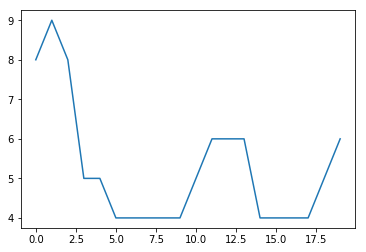

In [12]:
plt.plot(r_theta)
print(np.mean(r_theta))

In [13]:
R_0_list = np.array(R_0_list)
R_0 = np.mean(R_0_list)
print(R_0_list)
print(R_0)

[1.05487043e-08 1.06239040e-08 1.04221659e-08 ... 1.05235184e-08
 1.02596437e-08 1.02768724e-08]
1.0428233121674043e-08


In [14]:
R_mean_list = np.array(R_mean_list)
R_mean = np.mean(R_mean_list)
print(R_mean_list)
print(R_mean)

[5.55 5.6  5.5  ... 5.4  5.25 5.25]
5.441767316017316


In [15]:
r_q_pow_ar = np.array(r_q_pow_list)
print(r_q_pow_ar.shape)
print(r_q_pow_ar)

(11, 2000)
[[1.21603396e+03 1.23804318e+03 1.19422213e+03 ... 1.15119066e+03
  1.08812389e+03 1.08812389e+03]
 [4.73595907e-02 3.93735869e-01 2.32346119e-01 ... 7.18282494e+00
  3.51715786e+00 9.78667979e+00]
 [4.45912081e+00 4.23292961e+00 4.23292961e+00 ... 2.57292634e+01
  2.47101046e+01 2.81767648e+01]
 ...
 [3.07088416e-01 2.78289299e-01 5.20980930e-02 ... 1.74093113e-01
  1.00686014e+00 1.98997008e-02]
 [4.22821654e-01 9.12611679e-01 1.59078062e+00 ... 3.35873236e-01
  6.56875104e-01 6.53100309e-01]
 [8.88264396e-01 0.00000000e+00 0.00000000e+00 ... 1.57913670e+00
  9.86960440e-02 9.86960440e-02]]


In [16]:
r_q_pow_ave = np.zeros(lq)
print(r_q_pow_ave)

for i in range(lq):
    r_q_pow_ave[i]=np.mean(r_q_pow_ar[i])

print(r_q_pow_ave)
print(r_q_pow_ave.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1.17352626e+03 3.14578857e+00 8.86865846e+00 2.88181488e+00
 1.85081412e+00 1.55425378e+00 1.19447878e+00 9.16712282e-01
 8.34029039e-01 7.69934547e-01 7.55308336e-01]
(11,)


In [17]:
power_sp = r_q_pow_ave * 1/R_mean**2 # R_mean en unités de delta_r
print(power_sp)

[3.96289785e+01 1.06230590e-01 2.99487013e-01 9.73164243e-02
 6.25004104e-02 5.24858213e-02 4.03365272e-02 3.09565899e-02
 2.81644475e-02 2.60000313e-02 2.55061167e-02]


In [18]:
R_mean_real = R_mean*delta_r # en m
print(R_mean_real)

1.0235964321428572e-08


In [19]:
print(R_0)

1.0428233121674043e-08


In [20]:
np.save(path_res+'power_sp'+name+'.npy', power_sp)
np.save(path_res+'R0'+name+'.npy', R_0)

# Load from file

In [13]:
l_ave = np.load(path_res+'power_sp'+name+'.npy')
R_0 = np.load(path_res+'R0'+name+'.npy')
print(q)
print(np.shape(q))
print(np.shape(l_ave))
print(R_0)

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
(11,)
(11,)
1.0428233121674043e-08


Text(0,0.5,'$<|r(q)|²>$')

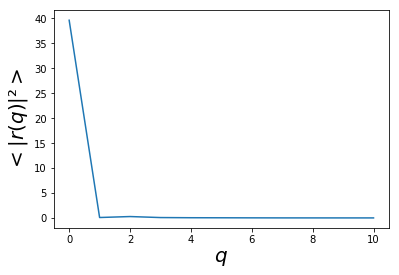

In [14]:
plt.plot(l_ave)

plt.xlabel('$q$',fontsize=20)
plt.ylabel('$<|r(q)|²>$',fontsize=20)

Text(0,0.5,'$q⁴ <|r(q)|²>$')

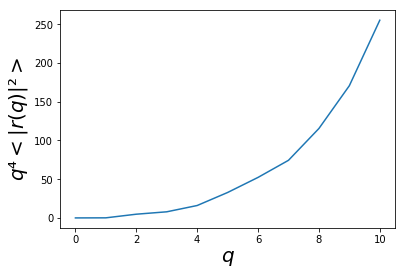

In [15]:
plt.plot(l_ave*q**4)

plt.xlabel('$q$',fontsize=20)
plt.ylabel('$q⁴ <|r(q)|²>$',fontsize=20)

In [24]:
qmin = 2
qmax = 6
q2inv = 1/(q[qmin:qmax]**2-1)
print(q2inv)
varq = l_ave[qmin:qmax]

[0.33333333 0.125      0.06666667 0.04166667]


Text(0,0.5,'$<|r(q)|²>$')

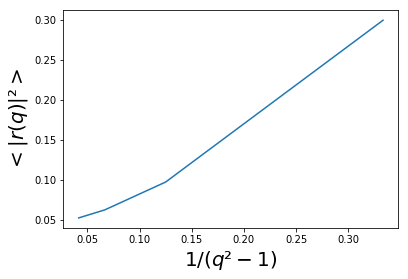

In [25]:
plt.plot(q2inv,varq)

plt.xlabel('$1/(q²-1)$',fontsize=20)
plt.ylabel('$<|r(q)|²>$',fontsize=20)

[0.         0.89038616]


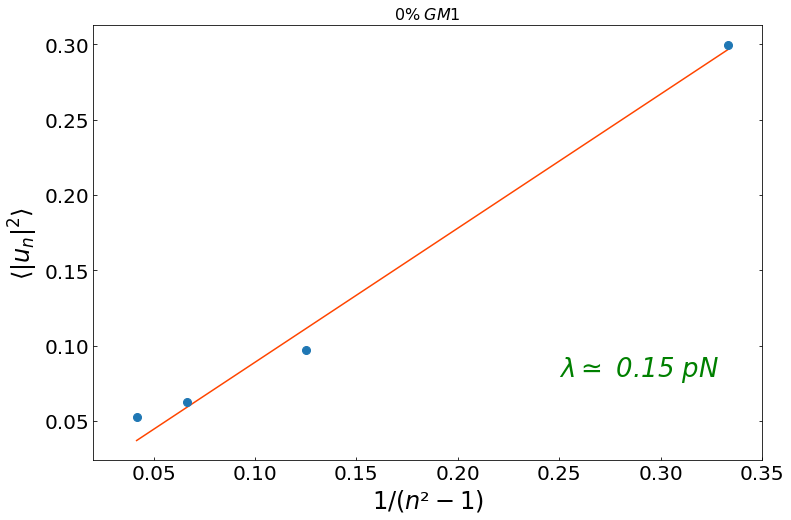

In [39]:
#rc('text', usetex=True)  # LaTeX
from numpy.polynomial import polynomial as P

pi = np.pi
fig, ax = plt.subplots(figsize=(12, 8))

pfit = P.polyfit(q2inv, varq, [1])
print(pfit)

ax.plot(q2inv, pfit[1]*q2inv+pfit[0], 'orangered')
ax.plot(q2inv, varq, '.', markersize=16)


lamb = 1.38*10**(-23)*310/pi/R_0/pfit[1]*10**(12)



plt.xlabel('$1/(n²-1)$',fontsize=24)
plt.ylabel(r'$ \langle |u_n|^2 \rangle $',fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.annotate('$\lambda \simeq$ %.2f pN' % lamb, color='g', fontsize=26, style='italic', xy=(0.2,0.08), xytext=(0.25,0.08))

xmin = 0.02
xmax = 0.35
plt.xlim(xmin,xmax)

ax.set_title('$0\% \; GM1$', fontsize=16)
ax.tick_params(labelsize=20)

ax.xaxis.set_tick_params(direction="in", which="both")
ax.yaxis.set_tick_params(direction="in", right=True, which="both")

plt.savefig(path_res+'line_tension'+name+params+'.pdf', format='pdf',bbox_inches='tight')